In [1]:
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np
import pandas as pd
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
%matplotlib inline 

/home/ejrueda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Esquema de una GANs
- Generator: es la red que se encarga de producir imágenes falsas, para tratar de engañar al discriminador.
- Discriminator: recibe imágenes falsas y reales, y se entrena para que pueda predecir la autencicidad de cada una.

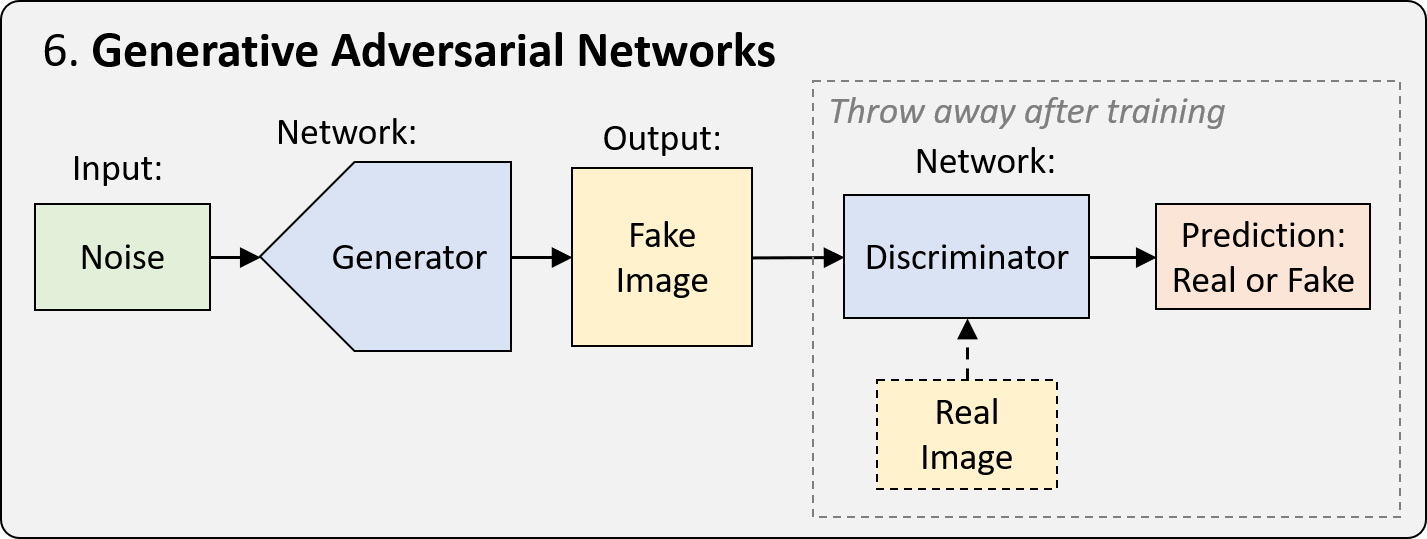

In [2]:
from IPython.display import Image
Image(filename="GANs_arquitectura.png")

#### Se carga el MNIST con el que se va a probar la arquitectura.

In [3]:
data_train = pd.read_csv("./data/train.csv")
data_test = pd.read_csv("./data/test.csv")
data_train.shape, data_test.shape

((42000, 785), (28000, 784))

In [4]:
data_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


-- Imágenes originales --


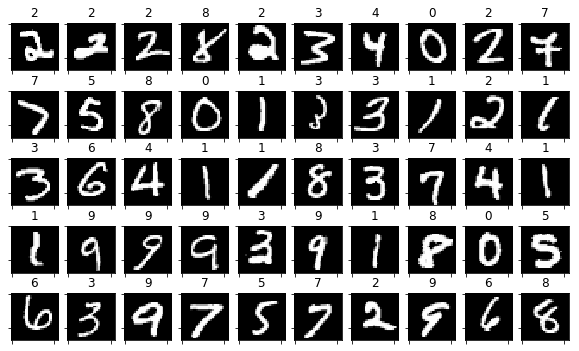

In [9]:
num_imgs = 50 #número de imágenes a mostrar aleatoriamente
fig = plt.figure(figsize=(10,6))
print("-- Imágenes originales --")
for i in range(num_imgs):
    ax=fig.add_subplot(5,10,i+1)
    rdm_img = np.random.randint(1,data_train.shape[0]-1)
    plt.imshow(np.array(data_train.iloc[rdm_img,1:]).reshape(28,28), cmap = plt.cm.Greys_r)
    ax.set_title(int(data_train.iloc[rdm_img,0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#### Ejemplo del generador de ruido:
- se generan imágenes a partir de una distribución gausiana, para con ellas estimar la nuevas imágenes.

In [10]:
#se crea el modelo secuencial el cual hará las veces de generador de ruido
model = Sequential()
model.add(Dense(256, input_shape=(100,)))
model.add(LeakyReLU(alpha=0.2)) #función rectificadora
model.add(Dropout(0.1))
model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1024))
model.add(Dropout(0.1))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(28  * 28 * 1, activation='tanh'))
model.add(Reshape((28, 28, 1)))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))

In [11]:
#model.summary()
batch = 640
gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
syntetic_images = model.predict(gen_noise)
print("Imágenes: ",syntetic_images.shape)

Imágenes:  (320, 28, 28, 1)


imágenes que genera el modelo


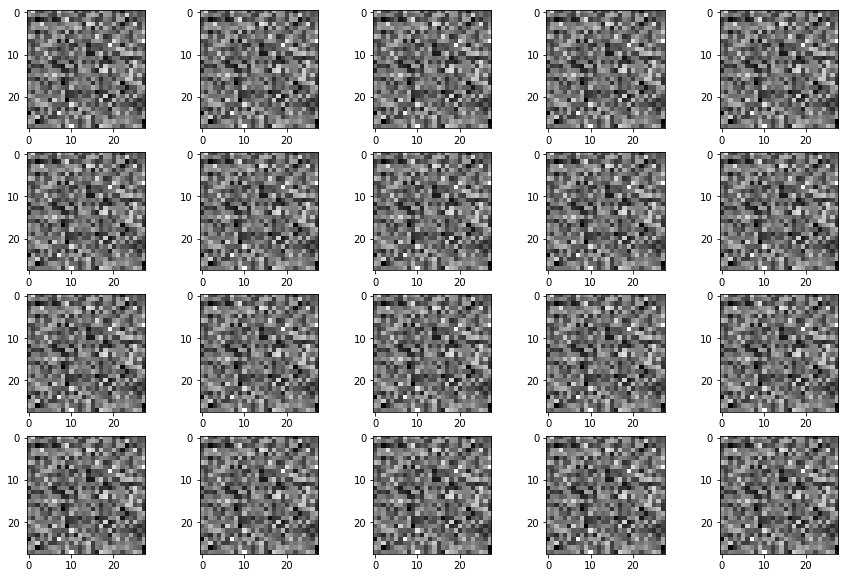

In [12]:
num_imgs = 20
plt.figure(figsize=(15,10))
print("imágenes que genera el modelo")
for i in range(num_imgs):
    plt.subplot(4,5,i+1)
    img_idx = np.random.randint(0,syntetic_images.shape[0])
    plt.imshow(syntetic_images[0,:,:].reshape(28,28), cmap="gray")

## Generative Adversarial Networks - GANs
- Se crea una clase llamada "GANs" y en ella se define tanto el generador como el discriminador, tambien el método para unir los dos modelos "__stacked_generator_discriminator". Por último se crea el método train el cual entrena la red.

In [17]:
import os
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

class GANs:
    #inicialización de variables
    def __init__(self, width=28, height=28, channels=1):
        #para retornar las imágenes
        self.WIDTH = width
        self.HEIGHT = height
        self.CHANNELS = channels
        self.SHAPE = (width, height, channels)
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5, decay=8e-8)
        self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.G = self.noise_generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        #print("Compilando el generador...")
        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        #print("Compilando el discriminador...")
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #Para unir el generador y el disctiminador
    def __stacked_generator_discriminator(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    #generador de ruido
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        #model.add(Dropout(0.1))
        model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
        model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        #model.add(Dropout(0.1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.WIDTH  * self.HEIGHT * self.CHANNELS, activation='tanh'))
        model.add(Reshape((self.WIDTH, self.HEIGHT, self.CHANNELS)))
        return model

    #Discriminador del modelo
    def discriminator(self):    
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.WIDTH * self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.WIDTH * self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()
        return model
    
    #Entrenar la GANs
    def train(self, X_train, epochs, batch):
        ## train discriminator
        Imgs = []
        for cnt in range(epochs):
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            legit_images = X_train[random_index:random_index + np.int64(batch/2)].reshape(np.int64(batch/2),
                                                                                            self.WIDTH,
                                                                                            self.HEIGHT,
                                                                                            self.CHANNELS)
            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            #print(gen_noise.shape)
            syntetic_images = self.G.predict(gen_noise)
            #print(legit_images.shape, syntetic_images.shape)
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)),
                                               np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator
            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0],
                                                                                           g_loss))
            #bined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))
            if (cnt % 100) ==0: #para dibujar solos módulos de 100
                Imgs.append(self.plot_images(save2file=True, samples=20, step=cnt))
                print(np.array(Imgs).shape)
        return Imgs
            
    def plot_images(self, save2file=False, samples=20, step=0):
        # Para pintar o guardar las imágenes
        if not os.path.exists("./images"):
            os.makedirs("./images")
        filename = "./images/mnist_" + str(step) + ".png"
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)
        #print(images.shape)
        plt.figure(figsize=(10, 10))

        for i in range(images.shape[0]):
            plt.subplot(4, 5, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.HEIGHT, self.WIDTH])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
        return images

In [18]:
X_train = np.array(data_train.iloc[:,1:])
y_train = np.array(data_train.iloc[:,0])

In [19]:
m = 255/2
X_train = (X_train.astype(np.float32) - m) / m
X_train = np.expand_dims(X_train, axis=3)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
#np.expand_dims - Para expandir las dimensiones de un array

In [21]:
gan = GANs()
l_img = gan.train(X_train,epochs=10000,batch=128)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.545998], [ Generator :: loss: 0.521761]
(1, 20, 28, 28, 1)
epoch: 1, [Discriminator :: d_loss: 0.582758], [ Generator :: loss: 0.563395]
epoch: 2, [Discriminator :: d_loss: 0.493913], [ Generator :: loss: 0.614271]
epoch: 3, [Discriminator :: d_loss: 0.434439], [ Generator :: loss: 0.710279]
epoch: 4, [Discriminator :: d_loss: 0.376577], [ Generator :: loss: 0.800831]
epoch: 5, [Discriminator :: d_loss: 0.370609], [ Generator :: loss: 0.901116]
epoch: 6, [Discriminator :: d_loss: 0.292996], [ Generator :: loss: 1.033004]
epoch: 7, [Discriminator :: d_loss: 0.244778], [ Generator :: loss: 1.125751]
epoch: 8, [Discriminator :: d_loss: 0.223677], [ Generator :: loss: 1.236432]
epoch: 9, [Discriminator :: d_loss: 0.207990], [ Generator :: loss: 1.340975]
epoch: 10, [Discriminator :: d_loss: 0.180607], [ Generator :: loss: 1.394050]
epoch: 11, [Discriminator :: d_loss: 0.169831], [ Generator :: loss: 1.538238]
epoch: 12, [Discriminator :: d_loss: 0.1727

epoch: 104, [Discriminator :: d_loss: 0.016322], [ Generator :: loss: 4.072184]
epoch: 105, [Discriminator :: d_loss: 0.015822], [ Generator :: loss: 4.120157]
epoch: 106, [Discriminator :: d_loss: 0.016942], [ Generator :: loss: 4.132675]
epoch: 107, [Discriminator :: d_loss: 0.016287], [ Generator :: loss: 4.145176]
epoch: 108, [Discriminator :: d_loss: 0.013023], [ Generator :: loss: 4.140951]
epoch: 109, [Discriminator :: d_loss: 0.013416], [ Generator :: loss: 4.086624]
epoch: 110, [Discriminator :: d_loss: 0.014900], [ Generator :: loss: 4.088211]
epoch: 111, [Discriminator :: d_loss: 0.016798], [ Generator :: loss: 4.174090]
epoch: 112, [Discriminator :: d_loss: 0.014248], [ Generator :: loss: 4.210472]
epoch: 113, [Discriminator :: d_loss: 0.012558], [ Generator :: loss: 4.152468]
epoch: 114, [Discriminator :: d_loss: 0.016118], [ Generator :: loss: 4.192742]
epoch: 115, [Discriminator :: d_loss: 0.015748], [ Generator :: loss: 4.091461]
epoch: 116, [Discriminator :: d_loss: 0.

epoch: 208, [Discriminator :: d_loss: 0.092151], [ Generator :: loss: 3.806813]
epoch: 209, [Discriminator :: d_loss: 0.175435], [ Generator :: loss: 2.927032]
epoch: 210, [Discriminator :: d_loss: 0.114873], [ Generator :: loss: 2.713908]
epoch: 211, [Discriminator :: d_loss: 0.101651], [ Generator :: loss: 3.279526]
epoch: 212, [Discriminator :: d_loss: 0.064858], [ Generator :: loss: 3.728551]
epoch: 213, [Discriminator :: d_loss: 0.151428], [ Generator :: loss: 2.848740]
epoch: 214, [Discriminator :: d_loss: 0.210878], [ Generator :: loss: 2.959014]
epoch: 215, [Discriminator :: d_loss: 0.089096], [ Generator :: loss: 3.691136]
epoch: 216, [Discriminator :: d_loss: 0.122664], [ Generator :: loss: 3.307643]
epoch: 217, [Discriminator :: d_loss: 0.126504], [ Generator :: loss: 3.704319]
epoch: 218, [Discriminator :: d_loss: 0.173547], [ Generator :: loss: 2.609160]
epoch: 219, [Discriminator :: d_loss: 0.332764], [ Generator :: loss: 2.403672]
epoch: 220, [Discriminator :: d_loss: 0.

epoch: 312, [Discriminator :: d_loss: 0.213776], [ Generator :: loss: 2.129922]
epoch: 313, [Discriminator :: d_loss: 0.219359], [ Generator :: loss: 1.647149]
epoch: 314, [Discriminator :: d_loss: 0.250582], [ Generator :: loss: 2.125036]
epoch: 315, [Discriminator :: d_loss: 0.321274], [ Generator :: loss: 1.564712]
epoch: 316, [Discriminator :: d_loss: 0.287034], [ Generator :: loss: 2.207131]
epoch: 317, [Discriminator :: d_loss: 0.289375], [ Generator :: loss: 1.805012]
epoch: 318, [Discriminator :: d_loss: 0.251286], [ Generator :: loss: 1.740798]
epoch: 319, [Discriminator :: d_loss: 0.290931], [ Generator :: loss: 1.350762]
epoch: 320, [Discriminator :: d_loss: 0.314241], [ Generator :: loss: 1.885067]
epoch: 321, [Discriminator :: d_loss: 0.321255], [ Generator :: loss: 1.502716]
epoch: 322, [Discriminator :: d_loss: 0.292632], [ Generator :: loss: 1.571234]
epoch: 323, [Discriminator :: d_loss: 0.328215], [ Generator :: loss: 1.927703]
epoch: 324, [Discriminator :: d_loss: 0.

epoch: 416, [Discriminator :: d_loss: 0.541039], [ Generator :: loss: 0.906862]
epoch: 417, [Discriminator :: d_loss: 0.572130], [ Generator :: loss: 0.499505]
epoch: 418, [Discriminator :: d_loss: 0.572644], [ Generator :: loss: 1.210973]
epoch: 419, [Discriminator :: d_loss: 0.649717], [ Generator :: loss: 0.294504]
epoch: 420, [Discriminator :: d_loss: 0.736861], [ Generator :: loss: 0.849868]
epoch: 421, [Discriminator :: d_loss: 0.502361], [ Generator :: loss: 1.049085]
epoch: 422, [Discriminator :: d_loss: 0.554370], [ Generator :: loss: 0.416349]
epoch: 423, [Discriminator :: d_loss: 0.674323], [ Generator :: loss: 0.884744]
epoch: 424, [Discriminator :: d_loss: 0.588082], [ Generator :: loss: 0.699177]
epoch: 425, [Discriminator :: d_loss: 0.590061], [ Generator :: loss: 0.698285]
epoch: 426, [Discriminator :: d_loss: 0.532321], [ Generator :: loss: 0.872875]
epoch: 427, [Discriminator :: d_loss: 0.573056], [ Generator :: loss: 0.692543]
epoch: 428, [Discriminator :: d_loss: 0.

epoch: 520, [Discriminator :: d_loss: 0.549927], [ Generator :: loss: 1.228148]
epoch: 521, [Discriminator :: d_loss: 0.560240], [ Generator :: loss: 0.411460]
epoch: 522, [Discriminator :: d_loss: 0.612008], [ Generator :: loss: 1.249929]
epoch: 523, [Discriminator :: d_loss: 0.531082], [ Generator :: loss: 0.520650]
epoch: 524, [Discriminator :: d_loss: 0.533246], [ Generator :: loss: 1.119340]
epoch: 525, [Discriminator :: d_loss: 0.495638], [ Generator :: loss: 0.606461]
epoch: 526, [Discriminator :: d_loss: 0.517482], [ Generator :: loss: 1.070831]
epoch: 527, [Discriminator :: d_loss: 0.482590], [ Generator :: loss: 0.629109]
epoch: 528, [Discriminator :: d_loss: 0.490724], [ Generator :: loss: 1.036969]
epoch: 529, [Discriminator :: d_loss: 0.491807], [ Generator :: loss: 0.729690]
epoch: 530, [Discriminator :: d_loss: 0.476261], [ Generator :: loss: 1.011000]
epoch: 531, [Discriminator :: d_loss: 0.488025], [ Generator :: loss: 0.682432]
epoch: 532, [Discriminator :: d_loss: 0.

epoch: 624, [Discriminator :: d_loss: 0.498683], [ Generator :: loss: 1.280709]
epoch: 625, [Discriminator :: d_loss: 0.537577], [ Generator :: loss: 0.409725]
epoch: 626, [Discriminator :: d_loss: 0.622778], [ Generator :: loss: 1.387754]
epoch: 627, [Discriminator :: d_loss: 0.582180], [ Generator :: loss: 0.419484]
epoch: 628, [Discriminator :: d_loss: 0.616686], [ Generator :: loss: 1.299510]
epoch: 629, [Discriminator :: d_loss: 0.528197], [ Generator :: loss: 0.512105]
epoch: 630, [Discriminator :: d_loss: 0.555442], [ Generator :: loss: 1.286974]
epoch: 631, [Discriminator :: d_loss: 0.537851], [ Generator :: loss: 0.465553]
epoch: 632, [Discriminator :: d_loss: 0.588651], [ Generator :: loss: 1.259994]
epoch: 633, [Discriminator :: d_loss: 0.514028], [ Generator :: loss: 0.591260]
epoch: 634, [Discriminator :: d_loss: 0.529649], [ Generator :: loss: 1.139806]
epoch: 635, [Discriminator :: d_loss: 0.483031], [ Generator :: loss: 0.677404]
epoch: 636, [Discriminator :: d_loss: 0.

epoch: 728, [Discriminator :: d_loss: 0.536403], [ Generator :: loss: 1.071533]
epoch: 729, [Discriminator :: d_loss: 0.503480], [ Generator :: loss: 0.742767]
epoch: 730, [Discriminator :: d_loss: 0.486417], [ Generator :: loss: 1.031361]
epoch: 731, [Discriminator :: d_loss: 0.508562], [ Generator :: loss: 0.683282]
epoch: 732, [Discriminator :: d_loss: 0.520525], [ Generator :: loss: 1.096067]
epoch: 733, [Discriminator :: d_loss: 0.520251], [ Generator :: loss: 0.548064]
epoch: 734, [Discriminator :: d_loss: 0.558407], [ Generator :: loss: 1.332777]
epoch: 735, [Discriminator :: d_loss: 0.566330], [ Generator :: loss: 0.474340]
epoch: 736, [Discriminator :: d_loss: 0.610586], [ Generator :: loss: 1.413840]
epoch: 737, [Discriminator :: d_loss: 0.610829], [ Generator :: loss: 0.403213]
epoch: 738, [Discriminator :: d_loss: 0.630633], [ Generator :: loss: 1.332904]
epoch: 739, [Discriminator :: d_loss: 0.608796], [ Generator :: loss: 0.484195]
epoch: 740, [Discriminator :: d_loss: 0.

epoch: 832, [Discriminator :: d_loss: 0.613716], [ Generator :: loss: 1.225136]
epoch: 833, [Discriminator :: d_loss: 0.573022], [ Generator :: loss: 0.573892]
epoch: 834, [Discriminator :: d_loss: 0.566576], [ Generator :: loss: 1.165967]
epoch: 835, [Discriminator :: d_loss: 0.560325], [ Generator :: loss: 0.597021]
epoch: 836, [Discriminator :: d_loss: 0.556878], [ Generator :: loss: 1.158192]
epoch: 837, [Discriminator :: d_loss: 0.537356], [ Generator :: loss: 0.644394]
epoch: 838, [Discriminator :: d_loss: 0.553768], [ Generator :: loss: 1.131154]
epoch: 839, [Discriminator :: d_loss: 0.549942], [ Generator :: loss: 0.528369]
epoch: 840, [Discriminator :: d_loss: 0.579949], [ Generator :: loss: 1.282954]
epoch: 841, [Discriminator :: d_loss: 0.594838], [ Generator :: loss: 0.460755]
epoch: 842, [Discriminator :: d_loss: 0.613433], [ Generator :: loss: 1.363131]
epoch: 843, [Discriminator :: d_loss: 0.606943], [ Generator :: loss: 0.460004]
epoch: 844, [Discriminator :: d_loss: 0.

epoch: 936, [Discriminator :: d_loss: 0.634688], [ Generator :: loss: 1.314318]
epoch: 937, [Discriminator :: d_loss: 0.608881], [ Generator :: loss: 0.445817]
epoch: 938, [Discriminator :: d_loss: 0.624889], [ Generator :: loss: 1.329255]
epoch: 939, [Discriminator :: d_loss: 0.609862], [ Generator :: loss: 0.495229]
epoch: 940, [Discriminator :: d_loss: 0.611240], [ Generator :: loss: 1.188365]
epoch: 941, [Discriminator :: d_loss: 0.581456], [ Generator :: loss: 0.591474]
epoch: 942, [Discriminator :: d_loss: 0.590431], [ Generator :: loss: 1.162928]
epoch: 943, [Discriminator :: d_loss: 0.576239], [ Generator :: loss: 0.561873]
epoch: 944, [Discriminator :: d_loss: 0.572291], [ Generator :: loss: 1.154899]
epoch: 945, [Discriminator :: d_loss: 0.572273], [ Generator :: loss: 0.671314]
epoch: 946, [Discriminator :: d_loss: 0.541575], [ Generator :: loss: 0.934280]
epoch: 947, [Discriminator :: d_loss: 0.528176], [ Generator :: loss: 0.854103]
epoch: 948, [Discriminator :: d_loss: 0.

epoch: 1039, [Discriminator :: d_loss: 0.621856], [ Generator :: loss: 1.357194]
epoch: 1040, [Discriminator :: d_loss: 0.635690], [ Generator :: loss: 0.508033]
epoch: 1041, [Discriminator :: d_loss: 0.622555], [ Generator :: loss: 1.198205]
epoch: 1042, [Discriminator :: d_loss: 0.571529], [ Generator :: loss: 0.667056]
epoch: 1043, [Discriminator :: d_loss: 0.575351], [ Generator :: loss: 1.002189]
epoch: 1044, [Discriminator :: d_loss: 0.535517], [ Generator :: loss: 0.803221]
epoch: 1045, [Discriminator :: d_loss: 0.550938], [ Generator :: loss: 0.827363]
epoch: 1046, [Discriminator :: d_loss: 0.557821], [ Generator :: loss: 0.892925]
epoch: 1047, [Discriminator :: d_loss: 0.569566], [ Generator :: loss: 0.750565]
epoch: 1048, [Discriminator :: d_loss: 0.560448], [ Generator :: loss: 0.986350]
epoch: 1049, [Discriminator :: d_loss: 0.588008], [ Generator :: loss: 0.699798]
epoch: 1050, [Discriminator :: d_loss: 0.576482], [ Generator :: loss: 0.972058]
epoch: 1051, [Discriminator 

epoch: 1140, [Discriminator :: d_loss: 0.593045], [ Generator :: loss: 1.236660]
epoch: 1141, [Discriminator :: d_loss: 0.540894], [ Generator :: loss: 0.674153]
epoch: 1142, [Discriminator :: d_loss: 0.578988], [ Generator :: loss: 1.119910]
epoch: 1143, [Discriminator :: d_loss: 0.569769], [ Generator :: loss: 0.681853]
epoch: 1144, [Discriminator :: d_loss: 0.582455], [ Generator :: loss: 1.161966]
epoch: 1145, [Discriminator :: d_loss: 0.564366], [ Generator :: loss: 0.609969]
epoch: 1146, [Discriminator :: d_loss: 0.579204], [ Generator :: loss: 1.182169]
epoch: 1147, [Discriminator :: d_loss: 0.598097], [ Generator :: loss: 0.538733]
epoch: 1148, [Discriminator :: d_loss: 0.607528], [ Generator :: loss: 1.292048]
epoch: 1149, [Discriminator :: d_loss: 0.588853], [ Generator :: loss: 0.541898]
epoch: 1150, [Discriminator :: d_loss: 0.594916], [ Generator :: loss: 1.257325]
epoch: 1151, [Discriminator :: d_loss: 0.563507], [ Generator :: loss: 0.607402]
epoch: 1152, [Discriminator 

epoch: 1244, [Discriminator :: d_loss: 0.600080], [ Generator :: loss: 1.223781]
epoch: 1245, [Discriminator :: d_loss: 0.645323], [ Generator :: loss: 0.463319]
epoch: 1246, [Discriminator :: d_loss: 0.646184], [ Generator :: loss: 1.349104]
epoch: 1247, [Discriminator :: d_loss: 0.649899], [ Generator :: loss: 0.505987]
epoch: 1248, [Discriminator :: d_loss: 0.657025], [ Generator :: loss: 1.192393]
epoch: 1249, [Discriminator :: d_loss: 0.593114], [ Generator :: loss: 0.637598]
epoch: 1250, [Discriminator :: d_loss: 0.597792], [ Generator :: loss: 1.059664]
epoch: 1251, [Discriminator :: d_loss: 0.599753], [ Generator :: loss: 0.651387]
epoch: 1252, [Discriminator :: d_loss: 0.586432], [ Generator :: loss: 1.096755]
epoch: 1253, [Discriminator :: d_loss: 0.607887], [ Generator :: loss: 0.528792]
epoch: 1254, [Discriminator :: d_loss: 0.636888], [ Generator :: loss: 1.119966]
epoch: 1255, [Discriminator :: d_loss: 0.604836], [ Generator :: loss: 0.639395]
epoch: 1256, [Discriminator 

epoch: 1348, [Discriminator :: d_loss: 0.691839], [ Generator :: loss: 1.562177]
epoch: 1349, [Discriminator :: d_loss: 0.677221], [ Generator :: loss: 0.420656]
epoch: 1350, [Discriminator :: d_loss: 0.676494], [ Generator :: loss: 1.298355]
epoch: 1351, [Discriminator :: d_loss: 0.626640], [ Generator :: loss: 0.597826]
epoch: 1352, [Discriminator :: d_loss: 0.587151], [ Generator :: loss: 1.003249]
epoch: 1353, [Discriminator :: d_loss: 0.572895], [ Generator :: loss: 0.874349]
epoch: 1354, [Discriminator :: d_loss: 0.588330], [ Generator :: loss: 0.751518]
epoch: 1355, [Discriminator :: d_loss: 0.547541], [ Generator :: loss: 1.138000]
epoch: 1356, [Discriminator :: d_loss: 0.557642], [ Generator :: loss: 0.693902]
epoch: 1357, [Discriminator :: d_loss: 0.560267], [ Generator :: loss: 1.123458]
epoch: 1358, [Discriminator :: d_loss: 0.586224], [ Generator :: loss: 0.678173]
epoch: 1359, [Discriminator :: d_loss: 0.613923], [ Generator :: loss: 0.969430]
epoch: 1360, [Discriminator 

epoch: 1452, [Discriminator :: d_loss: 0.609914], [ Generator :: loss: 0.660001]
epoch: 1453, [Discriminator :: d_loss: 0.589101], [ Generator :: loss: 1.296536]
epoch: 1454, [Discriminator :: d_loss: 0.592430], [ Generator :: loss: 0.574821]
epoch: 1455, [Discriminator :: d_loss: 0.644138], [ Generator :: loss: 1.174628]
epoch: 1456, [Discriminator :: d_loss: 0.613967], [ Generator :: loss: 0.594891]
epoch: 1457, [Discriminator :: d_loss: 0.640188], [ Generator :: loss: 1.087045]
epoch: 1458, [Discriminator :: d_loss: 0.592139], [ Generator :: loss: 0.648380]
epoch: 1459, [Discriminator :: d_loss: 0.587139], [ Generator :: loss: 1.335294]
epoch: 1460, [Discriminator :: d_loss: 0.631327], [ Generator :: loss: 0.602534]
epoch: 1461, [Discriminator :: d_loss: 0.599103], [ Generator :: loss: 1.249910]
epoch: 1462, [Discriminator :: d_loss: 0.625329], [ Generator :: loss: 0.639198]
epoch: 1463, [Discriminator :: d_loss: 0.612781], [ Generator :: loss: 1.150419]
epoch: 1464, [Discriminator 

epoch: 1556, [Discriminator :: d_loss: 0.637400], [ Generator :: loss: 1.243002]
epoch: 1557, [Discriminator :: d_loss: 0.616359], [ Generator :: loss: 0.726918]
epoch: 1558, [Discriminator :: d_loss: 0.582307], [ Generator :: loss: 1.137732]
epoch: 1559, [Discriminator :: d_loss: 0.581077], [ Generator :: loss: 0.734942]
epoch: 1560, [Discriminator :: d_loss: 0.579895], [ Generator :: loss: 1.005513]
epoch: 1561, [Discriminator :: d_loss: 0.548967], [ Generator :: loss: 0.857891]
epoch: 1562, [Discriminator :: d_loss: 0.561030], [ Generator :: loss: 1.027664]
epoch: 1563, [Discriminator :: d_loss: 0.544161], [ Generator :: loss: 0.789735]
epoch: 1564, [Discriminator :: d_loss: 0.593683], [ Generator :: loss: 0.978219]
epoch: 1565, [Discriminator :: d_loss: 0.578617], [ Generator :: loss: 0.828842]
epoch: 1566, [Discriminator :: d_loss: 0.598099], [ Generator :: loss: 0.969679]
epoch: 1567, [Discriminator :: d_loss: 0.599466], [ Generator :: loss: 0.688974]
epoch: 1568, [Discriminator 

epoch: 1660, [Discriminator :: d_loss: 0.582859], [ Generator :: loss: 0.875796]
epoch: 1661, [Discriminator :: d_loss: 0.605272], [ Generator :: loss: 0.914002]
epoch: 1662, [Discriminator :: d_loss: 0.580856], [ Generator :: loss: 0.815994]
epoch: 1663, [Discriminator :: d_loss: 0.569689], [ Generator :: loss: 0.952589]
epoch: 1664, [Discriminator :: d_loss: 0.582072], [ Generator :: loss: 0.831097]
epoch: 1665, [Discriminator :: d_loss: 0.543965], [ Generator :: loss: 1.068141]
epoch: 1666, [Discriminator :: d_loss: 0.587141], [ Generator :: loss: 0.627581]
epoch: 1667, [Discriminator :: d_loss: 0.626887], [ Generator :: loss: 1.159961]
epoch: 1668, [Discriminator :: d_loss: 0.593211], [ Generator :: loss: 0.732685]
epoch: 1669, [Discriminator :: d_loss: 0.580714], [ Generator :: loss: 1.061404]
epoch: 1670, [Discriminator :: d_loss: 0.586892], [ Generator :: loss: 0.730368]
epoch: 1671, [Discriminator :: d_loss: 0.578421], [ Generator :: loss: 1.098169]
epoch: 1672, [Discriminator 

epoch: 1764, [Discriminator :: d_loss: 0.571888], [ Generator :: loss: 0.705744]
epoch: 1765, [Discriminator :: d_loss: 0.582026], [ Generator :: loss: 1.405015]
epoch: 1766, [Discriminator :: d_loss: 0.618741], [ Generator :: loss: 0.465537]
epoch: 1767, [Discriminator :: d_loss: 0.666431], [ Generator :: loss: 1.550622]
epoch: 1768, [Discriminator :: d_loss: 0.662644], [ Generator :: loss: 0.498631]
epoch: 1769, [Discriminator :: d_loss: 0.617820], [ Generator :: loss: 1.384122]
epoch: 1770, [Discriminator :: d_loss: 0.606978], [ Generator :: loss: 0.673097]
epoch: 1771, [Discriminator :: d_loss: 0.582548], [ Generator :: loss: 1.152569]
epoch: 1772, [Discriminator :: d_loss: 0.566252], [ Generator :: loss: 0.685680]
epoch: 1773, [Discriminator :: d_loss: 0.585288], [ Generator :: loss: 1.247876]
epoch: 1774, [Discriminator :: d_loss: 0.578598], [ Generator :: loss: 0.692927]
epoch: 1775, [Discriminator :: d_loss: 0.585669], [ Generator :: loss: 1.108135]
epoch: 1776, [Discriminator 

epoch: 1867, [Discriminator :: d_loss: 0.628700], [ Generator :: loss: 0.600810]
epoch: 1868, [Discriminator :: d_loss: 0.625893], [ Generator :: loss: 0.997117]
epoch: 1869, [Discriminator :: d_loss: 0.578678], [ Generator :: loss: 0.899302]
epoch: 1870, [Discriminator :: d_loss: 0.541564], [ Generator :: loss: 0.816152]
epoch: 1871, [Discriminator :: d_loss: 0.585635], [ Generator :: loss: 1.022264]
epoch: 1872, [Discriminator :: d_loss: 0.583070], [ Generator :: loss: 0.914955]
epoch: 1873, [Discriminator :: d_loss: 0.600529], [ Generator :: loss: 0.697194]
epoch: 1874, [Discriminator :: d_loss: 0.613113], [ Generator :: loss: 1.201698]
epoch: 1875, [Discriminator :: d_loss: 0.566092], [ Generator :: loss: 0.673667]
epoch: 1876, [Discriminator :: d_loss: 0.592793], [ Generator :: loss: 0.997204]
epoch: 1877, [Discriminator :: d_loss: 0.522186], [ Generator :: loss: 0.926114]
epoch: 1878, [Discriminator :: d_loss: 0.570461], [ Generator :: loss: 0.674458]
epoch: 1879, [Discriminator 

epoch: 1968, [Discriminator :: d_loss: 0.596748], [ Generator :: loss: 0.635718]
epoch: 1969, [Discriminator :: d_loss: 0.617858], [ Generator :: loss: 1.288683]
epoch: 1970, [Discriminator :: d_loss: 0.625553], [ Generator :: loss: 0.558022]
epoch: 1971, [Discriminator :: d_loss: 0.628807], [ Generator :: loss: 1.270523]
epoch: 1972, [Discriminator :: d_loss: 0.651135], [ Generator :: loss: 0.481616]
epoch: 1973, [Discriminator :: d_loss: 0.648633], [ Generator :: loss: 1.383595]
epoch: 1974, [Discriminator :: d_loss: 0.694916], [ Generator :: loss: 0.565881]
epoch: 1975, [Discriminator :: d_loss: 0.606521], [ Generator :: loss: 1.193616]
epoch: 1976, [Discriminator :: d_loss: 0.668415], [ Generator :: loss: 0.602506]
epoch: 1977, [Discriminator :: d_loss: 0.627676], [ Generator :: loss: 1.137742]
epoch: 1978, [Discriminator :: d_loss: 0.612027], [ Generator :: loss: 0.666648]
epoch: 1979, [Discriminator :: d_loss: 0.603440], [ Generator :: loss: 1.100134]
epoch: 1980, [Discriminator 

epoch: 2071, [Discriminator :: d_loss: 0.583501], [ Generator :: loss: 1.229159]
epoch: 2072, [Discriminator :: d_loss: 0.570397], [ Generator :: loss: 0.700386]
epoch: 2073, [Discriminator :: d_loss: 0.562219], [ Generator :: loss: 1.099743]
epoch: 2074, [Discriminator :: d_loss: 0.555978], [ Generator :: loss: 0.888458]
epoch: 2075, [Discriminator :: d_loss: 0.564664], [ Generator :: loss: 0.948267]
epoch: 2076, [Discriminator :: d_loss: 0.539027], [ Generator :: loss: 0.920835]
epoch: 2077, [Discriminator :: d_loss: 0.521630], [ Generator :: loss: 1.216437]
epoch: 2078, [Discriminator :: d_loss: 0.559447], [ Generator :: loss: 0.684876]
epoch: 2079, [Discriminator :: d_loss: 0.558500], [ Generator :: loss: 1.143003]
epoch: 2080, [Discriminator :: d_loss: 0.535881], [ Generator :: loss: 0.834022]
epoch: 2081, [Discriminator :: d_loss: 0.548516], [ Generator :: loss: 0.951251]
epoch: 2082, [Discriminator :: d_loss: 0.570506], [ Generator :: loss: 0.919738]
epoch: 2083, [Discriminator 

epoch: 2172, [Discriminator :: d_loss: 0.563129], [ Generator :: loss: 0.690108]
epoch: 2173, [Discriminator :: d_loss: 0.569669], [ Generator :: loss: 1.357498]
epoch: 2174, [Discriminator :: d_loss: 0.607073], [ Generator :: loss: 0.536051]
epoch: 2175, [Discriminator :: d_loss: 0.628823], [ Generator :: loss: 1.295167]
epoch: 2176, [Discriminator :: d_loss: 0.600757], [ Generator :: loss: 0.697015]
epoch: 2177, [Discriminator :: d_loss: 0.591243], [ Generator :: loss: 1.145712]
epoch: 2178, [Discriminator :: d_loss: 0.577518], [ Generator :: loss: 0.752387]
epoch: 2179, [Discriminator :: d_loss: 0.571360], [ Generator :: loss: 1.142343]
epoch: 2180, [Discriminator :: d_loss: 0.595870], [ Generator :: loss: 0.698830]
epoch: 2181, [Discriminator :: d_loss: 0.594818], [ Generator :: loss: 1.270948]
epoch: 2182, [Discriminator :: d_loss: 0.547240], [ Generator :: loss: 0.765610]
epoch: 2183, [Discriminator :: d_loss: 0.590906], [ Generator :: loss: 0.919534]
epoch: 2184, [Discriminator 

epoch: 2276, [Discriminator :: d_loss: 0.641983], [ Generator :: loss: 1.367082]
epoch: 2277, [Discriminator :: d_loss: 0.553163], [ Generator :: loss: 0.800558]
epoch: 2278, [Discriminator :: d_loss: 0.552912], [ Generator :: loss: 0.846637]
epoch: 2279, [Discriminator :: d_loss: 0.564065], [ Generator :: loss: 0.940272]
epoch: 2280, [Discriminator :: d_loss: 0.541276], [ Generator :: loss: 0.961324]
epoch: 2281, [Discriminator :: d_loss: 0.538718], [ Generator :: loss: 1.008459]
epoch: 2282, [Discriminator :: d_loss: 0.589146], [ Generator :: loss: 0.752626]
epoch: 2283, [Discriminator :: d_loss: 0.562742], [ Generator :: loss: 0.923975]
epoch: 2284, [Discriminator :: d_loss: 0.537280], [ Generator :: loss: 1.087615]
epoch: 2285, [Discriminator :: d_loss: 0.546773], [ Generator :: loss: 0.746790]
epoch: 2286, [Discriminator :: d_loss: 0.585528], [ Generator :: loss: 1.118919]
epoch: 2287, [Discriminator :: d_loss: 0.534997], [ Generator :: loss: 0.797113]
epoch: 2288, [Discriminator 

epoch: 2378, [Discriminator :: d_loss: 0.502505], [ Generator :: loss: 1.125666]
epoch: 2379, [Discriminator :: d_loss: 0.528657], [ Generator :: loss: 0.796454]
epoch: 2380, [Discriminator :: d_loss: 0.503940], [ Generator :: loss: 1.276493]
epoch: 2381, [Discriminator :: d_loss: 0.558543], [ Generator :: loss: 0.794831]
epoch: 2382, [Discriminator :: d_loss: 0.523732], [ Generator :: loss: 1.125597]
epoch: 2383, [Discriminator :: d_loss: 0.505044], [ Generator :: loss: 0.967312]
epoch: 2384, [Discriminator :: d_loss: 0.510433], [ Generator :: loss: 1.013964]
epoch: 2385, [Discriminator :: d_loss: 0.563769], [ Generator :: loss: 1.025608]
epoch: 2386, [Discriminator :: d_loss: 0.529844], [ Generator :: loss: 0.805378]
epoch: 2387, [Discriminator :: d_loss: 0.546622], [ Generator :: loss: 1.144274]
epoch: 2388, [Discriminator :: d_loss: 0.525326], [ Generator :: loss: 0.887292]
epoch: 2389, [Discriminator :: d_loss: 0.548559], [ Generator :: loss: 0.885405]
epoch: 2390, [Discriminator 

epoch: 2480, [Discriminator :: d_loss: 0.591030], [ Generator :: loss: 1.593088]
epoch: 2481, [Discriminator :: d_loss: 0.636416], [ Generator :: loss: 0.504832]
epoch: 2482, [Discriminator :: d_loss: 0.638868], [ Generator :: loss: 1.658969]
epoch: 2483, [Discriminator :: d_loss: 0.641330], [ Generator :: loss: 0.603817]
epoch: 2484, [Discriminator :: d_loss: 0.573442], [ Generator :: loss: 1.195644]
epoch: 2485, [Discriminator :: d_loss: 0.535354], [ Generator :: loss: 0.935388]
epoch: 2486, [Discriminator :: d_loss: 0.530940], [ Generator :: loss: 0.960329]
epoch: 2487, [Discriminator :: d_loss: 0.513960], [ Generator :: loss: 1.286584]
epoch: 2488, [Discriminator :: d_loss: 0.600803], [ Generator :: loss: 0.566804]
epoch: 2489, [Discriminator :: d_loss: 0.605747], [ Generator :: loss: 1.781994]
epoch: 2490, [Discriminator :: d_loss: 0.641074], [ Generator :: loss: 0.559085]
epoch: 2491, [Discriminator :: d_loss: 0.604241], [ Generator :: loss: 1.632783]
epoch: 2492, [Discriminator 

epoch: 2582, [Discriminator :: d_loss: 0.610197], [ Generator :: loss: 1.215892]
epoch: 2583, [Discriminator :: d_loss: 0.616614], [ Generator :: loss: 0.738259]
epoch: 2584, [Discriminator :: d_loss: 0.623927], [ Generator :: loss: 0.894566]
epoch: 2585, [Discriminator :: d_loss: 0.556166], [ Generator :: loss: 1.047815]
epoch: 2586, [Discriminator :: d_loss: 0.577078], [ Generator :: loss: 0.750478]
epoch: 2587, [Discriminator :: d_loss: 0.623449], [ Generator :: loss: 1.014749]
epoch: 2588, [Discriminator :: d_loss: 0.657131], [ Generator :: loss: 0.541269]
epoch: 2589, [Discriminator :: d_loss: 0.644375], [ Generator :: loss: 1.414082]
epoch: 2590, [Discriminator :: d_loss: 0.753285], [ Generator :: loss: 0.397668]
epoch: 2591, [Discriminator :: d_loss: 0.726387], [ Generator :: loss: 1.632153]
epoch: 2592, [Discriminator :: d_loss: 0.716332], [ Generator :: loss: 0.545925]
epoch: 2593, [Discriminator :: d_loss: 0.697199], [ Generator :: loss: 1.234201]
epoch: 2594, [Discriminator 

epoch: 2686, [Discriminator :: d_loss: 0.613146], [ Generator :: loss: 1.162643]
epoch: 2687, [Discriminator :: d_loss: 0.593420], [ Generator :: loss: 0.721426]
epoch: 2688, [Discriminator :: d_loss: 0.615400], [ Generator :: loss: 0.945688]
epoch: 2689, [Discriminator :: d_loss: 0.621016], [ Generator :: loss: 1.003563]
epoch: 2690, [Discriminator :: d_loss: 0.588351], [ Generator :: loss: 0.721134]
epoch: 2691, [Discriminator :: d_loss: 0.583820], [ Generator :: loss: 1.088548]
epoch: 2692, [Discriminator :: d_loss: 0.564751], [ Generator :: loss: 0.806521]
epoch: 2693, [Discriminator :: d_loss: 0.543042], [ Generator :: loss: 1.162836]
epoch: 2694, [Discriminator :: d_loss: 0.594873], [ Generator :: loss: 0.774745]
epoch: 2695, [Discriminator :: d_loss: 0.598090], [ Generator :: loss: 1.069595]
epoch: 2696, [Discriminator :: d_loss: 0.578823], [ Generator :: loss: 0.828258]
epoch: 2697, [Discriminator :: d_loss: 0.566334], [ Generator :: loss: 0.965311]
epoch: 2698, [Discriminator 

epoch: 2790, [Discriminator :: d_loss: 0.541051], [ Generator :: loss: 0.804230]
epoch: 2791, [Discriminator :: d_loss: 0.518910], [ Generator :: loss: 1.245522]
epoch: 2792, [Discriminator :: d_loss: 0.574502], [ Generator :: loss: 0.711520]
epoch: 2793, [Discriminator :: d_loss: 0.567258], [ Generator :: loss: 1.192901]
epoch: 2794, [Discriminator :: d_loss: 0.595962], [ Generator :: loss: 0.726533]
epoch: 2795, [Discriminator :: d_loss: 0.569099], [ Generator :: loss: 1.212695]
epoch: 2796, [Discriminator :: d_loss: 0.591981], [ Generator :: loss: 0.621008]
epoch: 2797, [Discriminator :: d_loss: 0.570348], [ Generator :: loss: 1.445043]
epoch: 2798, [Discriminator :: d_loss: 0.619175], [ Generator :: loss: 0.598593]
epoch: 2799, [Discriminator :: d_loss: 0.625439], [ Generator :: loss: 1.212281]
epoch: 2800, [Discriminator :: d_loss: 0.587943], [ Generator :: loss: 0.695711]
(29, 20, 28, 28, 1)
epoch: 2801, [Discriminator :: d_loss: 0.574840], [ Generator :: loss: 1.295690]
epoch: 2

epoch: 2892, [Discriminator :: d_loss: 0.535939], [ Generator :: loss: 0.918712]
epoch: 2893, [Discriminator :: d_loss: 0.525313], [ Generator :: loss: 1.048891]
epoch: 2894, [Discriminator :: d_loss: 0.556686], [ Generator :: loss: 0.761932]
epoch: 2895, [Discriminator :: d_loss: 0.538117], [ Generator :: loss: 1.296874]
epoch: 2896, [Discriminator :: d_loss: 0.535957], [ Generator :: loss: 0.796029]
epoch: 2897, [Discriminator :: d_loss: 0.561538], [ Generator :: loss: 1.096971]
epoch: 2898, [Discriminator :: d_loss: 0.517525], [ Generator :: loss: 1.009885]
epoch: 2899, [Discriminator :: d_loss: 0.616077], [ Generator :: loss: 0.747157]
epoch: 2900, [Discriminator :: d_loss: 0.539310], [ Generator :: loss: 1.363205]
(30, 20, 28, 28, 1)
epoch: 2901, [Discriminator :: d_loss: 0.586143], [ Generator :: loss: 0.584023]
epoch: 2902, [Discriminator :: d_loss: 0.589133], [ Generator :: loss: 1.489560]
epoch: 2903, [Discriminator :: d_loss: 0.600949], [ Generator :: loss: 0.640041]
epoch: 2

epoch: 2994, [Discriminator :: d_loss: 0.579413], [ Generator :: loss: 0.961995]
epoch: 2995, [Discriminator :: d_loss: 0.523457], [ Generator :: loss: 1.117057]
epoch: 2996, [Discriminator :: d_loss: 0.625680], [ Generator :: loss: 0.599754]
epoch: 2997, [Discriminator :: d_loss: 0.615758], [ Generator :: loss: 1.287978]
epoch: 2998, [Discriminator :: d_loss: 0.551547], [ Generator :: loss: 0.839627]
epoch: 2999, [Discriminator :: d_loss: 0.600913], [ Generator :: loss: 0.882467]
epoch: 3000, [Discriminator :: d_loss: 0.526510], [ Generator :: loss: 1.163685]
(31, 20, 28, 28, 1)
epoch: 3001, [Discriminator :: d_loss: 0.590301], [ Generator :: loss: 0.687370]
epoch: 3002, [Discriminator :: d_loss: 0.623538], [ Generator :: loss: 1.223872]
epoch: 3003, [Discriminator :: d_loss: 0.604646], [ Generator :: loss: 0.807180]
epoch: 3004, [Discriminator :: d_loss: 0.579894], [ Generator :: loss: 1.134256]
epoch: 3005, [Discriminator :: d_loss: 0.569924], [ Generator :: loss: 0.798742]
epoch: 3

epoch: 3096, [Discriminator :: d_loss: 0.656394], [ Generator :: loss: 0.607710]
epoch: 3097, [Discriminator :: d_loss: 0.629626], [ Generator :: loss: 1.391804]
epoch: 3098, [Discriminator :: d_loss: 0.651509], [ Generator :: loss: 0.549126]
epoch: 3099, [Discriminator :: d_loss: 0.640557], [ Generator :: loss: 1.225708]
epoch: 3100, [Discriminator :: d_loss: 0.581274], [ Generator :: loss: 0.780763]
(32, 20, 28, 28, 1)
epoch: 3101, [Discriminator :: d_loss: 0.624362], [ Generator :: loss: 0.999063]
epoch: 3102, [Discriminator :: d_loss: 0.582335], [ Generator :: loss: 0.906165]
epoch: 3103, [Discriminator :: d_loss: 0.596773], [ Generator :: loss: 0.794520]
epoch: 3104, [Discriminator :: d_loss: 0.671087], [ Generator :: loss: 1.024590]
epoch: 3105, [Discriminator :: d_loss: 0.624294], [ Generator :: loss: 0.930548]
epoch: 3106, [Discriminator :: d_loss: 0.574683], [ Generator :: loss: 0.894689]
epoch: 3107, [Discriminator :: d_loss: 0.581034], [ Generator :: loss: 0.836710]
epoch: 3

epoch: 3200, [Discriminator :: d_loss: 0.623308], [ Generator :: loss: 0.554374]
(33, 20, 28, 28, 1)
epoch: 3201, [Discriminator :: d_loss: 0.668419], [ Generator :: loss: 1.323457]
epoch: 3202, [Discriminator :: d_loss: 0.610302], [ Generator :: loss: 0.698891]
epoch: 3203, [Discriminator :: d_loss: 0.629478], [ Generator :: loss: 0.805215]
epoch: 3204, [Discriminator :: d_loss: 0.589579], [ Generator :: loss: 1.193132]
epoch: 3205, [Discriminator :: d_loss: 0.590567], [ Generator :: loss: 0.628374]
epoch: 3206, [Discriminator :: d_loss: 0.594361], [ Generator :: loss: 1.207118]
epoch: 3207, [Discriminator :: d_loss: 0.663795], [ Generator :: loss: 0.561321]
epoch: 3208, [Discriminator :: d_loss: 0.645943], [ Generator :: loss: 1.260605]
epoch: 3209, [Discriminator :: d_loss: 0.625310], [ Generator :: loss: 0.694666]
epoch: 3210, [Discriminator :: d_loss: 0.623179], [ Generator :: loss: 1.065572]
epoch: 3211, [Discriminator :: d_loss: 0.567051], [ Generator :: loss: 0.799572]
epoch: 3

(34, 20, 28, 28, 1)
epoch: 3301, [Discriminator :: d_loss: 0.667912], [ Generator :: loss: 0.630553]
epoch: 3302, [Discriminator :: d_loss: 0.588604], [ Generator :: loss: 1.127981]
epoch: 3303, [Discriminator :: d_loss: 0.604901], [ Generator :: loss: 0.673170]
epoch: 3304, [Discriminator :: d_loss: 0.577179], [ Generator :: loss: 1.268115]
epoch: 3305, [Discriminator :: d_loss: 0.615835], [ Generator :: loss: 0.670186]
epoch: 3306, [Discriminator :: d_loss: 0.616886], [ Generator :: loss: 1.033628]
epoch: 3307, [Discriminator :: d_loss: 0.627821], [ Generator :: loss: 0.852934]
epoch: 3308, [Discriminator :: d_loss: 0.579647], [ Generator :: loss: 0.863382]
epoch: 3309, [Discriminator :: d_loss: 0.572151], [ Generator :: loss: 0.870199]
epoch: 3310, [Discriminator :: d_loss: 0.583017], [ Generator :: loss: 0.974844]
epoch: 3311, [Discriminator :: d_loss: 0.576211], [ Generator :: loss: 0.790517]
epoch: 3312, [Discriminator :: d_loss: 0.549110], [ Generator :: loss: 1.033710]
epoch: 3

epoch: 3403, [Discriminator :: d_loss: 0.622996], [ Generator :: loss: 1.184312]
epoch: 3404, [Discriminator :: d_loss: 0.578109], [ Generator :: loss: 0.809738]
epoch: 3405, [Discriminator :: d_loss: 0.557388], [ Generator :: loss: 1.071490]
epoch: 3406, [Discriminator :: d_loss: 0.582639], [ Generator :: loss: 0.794772]
epoch: 3407, [Discriminator :: d_loss: 0.554813], [ Generator :: loss: 1.166293]
epoch: 3408, [Discriminator :: d_loss: 0.597985], [ Generator :: loss: 0.713558]
epoch: 3409, [Discriminator :: d_loss: 0.596850], [ Generator :: loss: 1.097100]
epoch: 3410, [Discriminator :: d_loss: 0.545789], [ Generator :: loss: 0.976756]
epoch: 3411, [Discriminator :: d_loss: 0.574784], [ Generator :: loss: 0.666010]
epoch: 3412, [Discriminator :: d_loss: 0.602568], [ Generator :: loss: 1.311446]
epoch: 3413, [Discriminator :: d_loss: 0.585439], [ Generator :: loss: 0.635816]
epoch: 3414, [Discriminator :: d_loss: 0.599813], [ Generator :: loss: 1.238838]
epoch: 3415, [Discriminator 

epoch: 3506, [Discriminator :: d_loss: 0.558281], [ Generator :: loss: 1.119660]
epoch: 3507, [Discriminator :: d_loss: 0.580795], [ Generator :: loss: 0.804279]
epoch: 3508, [Discriminator :: d_loss: 0.552482], [ Generator :: loss: 1.203138]
epoch: 3509, [Discriminator :: d_loss: 0.579200], [ Generator :: loss: 0.703030]
epoch: 3510, [Discriminator :: d_loss: 0.584701], [ Generator :: loss: 1.142043]
epoch: 3511, [Discriminator :: d_loss: 0.654673], [ Generator :: loss: 0.694166]
epoch: 3512, [Discriminator :: d_loss: 0.561074], [ Generator :: loss: 1.152870]
epoch: 3513, [Discriminator :: d_loss: 0.574226], [ Generator :: loss: 0.813062]
epoch: 3514, [Discriminator :: d_loss: 0.603771], [ Generator :: loss: 0.968352]
epoch: 3515, [Discriminator :: d_loss: 0.562860], [ Generator :: loss: 0.937182]
epoch: 3516, [Discriminator :: d_loss: 0.573989], [ Generator :: loss: 0.841073]
epoch: 3517, [Discriminator :: d_loss: 0.569196], [ Generator :: loss: 1.081691]
epoch: 3518, [Discriminator 

epoch: 3608, [Discriminator :: d_loss: 0.540057], [ Generator :: loss: 1.015734]
epoch: 3609, [Discriminator :: d_loss: 0.542372], [ Generator :: loss: 0.891304]
epoch: 3610, [Discriminator :: d_loss: 0.583560], [ Generator :: loss: 0.806573]
epoch: 3611, [Discriminator :: d_loss: 0.542811], [ Generator :: loss: 1.219930]
epoch: 3612, [Discriminator :: d_loss: 0.589700], [ Generator :: loss: 0.619118]
epoch: 3613, [Discriminator :: d_loss: 0.607153], [ Generator :: loss: 1.145556]
epoch: 3614, [Discriminator :: d_loss: 0.642721], [ Generator :: loss: 0.726398]
epoch: 3615, [Discriminator :: d_loss: 0.618781], [ Generator :: loss: 0.993992]
epoch: 3616, [Discriminator :: d_loss: 0.603376], [ Generator :: loss: 0.772529]
epoch: 3617, [Discriminator :: d_loss: 0.569508], [ Generator :: loss: 1.083501]
epoch: 3618, [Discriminator :: d_loss: 0.569822], [ Generator :: loss: 0.919797]
epoch: 3619, [Discriminator :: d_loss: 0.574590], [ Generator :: loss: 1.000369]
epoch: 3620, [Discriminator 

epoch: 3711, [Discriminator :: d_loss: 0.605613], [ Generator :: loss: 1.213520]
epoch: 3712, [Discriminator :: d_loss: 0.580114], [ Generator :: loss: 0.578216]
epoch: 3713, [Discriminator :: d_loss: 0.653686], [ Generator :: loss: 1.355840]
epoch: 3714, [Discriminator :: d_loss: 0.638703], [ Generator :: loss: 0.615180]
epoch: 3715, [Discriminator :: d_loss: 0.650860], [ Generator :: loss: 1.170618]
epoch: 3716, [Discriminator :: d_loss: 0.597803], [ Generator :: loss: 0.858229]
epoch: 3717, [Discriminator :: d_loss: 0.571331], [ Generator :: loss: 0.842137]
epoch: 3718, [Discriminator :: d_loss: 0.561211], [ Generator :: loss: 0.944384]
epoch: 3719, [Discriminator :: d_loss: 0.621838], [ Generator :: loss: 0.909795]
epoch: 3720, [Discriminator :: d_loss: 0.615066], [ Generator :: loss: 0.754171]
epoch: 3721, [Discriminator :: d_loss: 0.578023], [ Generator :: loss: 1.008648]
epoch: 3722, [Discriminator :: d_loss: 0.588206], [ Generator :: loss: 0.860780]
epoch: 3723, [Discriminator 

epoch: 3812, [Discriminator :: d_loss: 0.632460], [ Generator :: loss: 0.912128]
epoch: 3813, [Discriminator :: d_loss: 0.588081], [ Generator :: loss: 1.114444]
epoch: 3814, [Discriminator :: d_loss: 0.583244], [ Generator :: loss: 0.633551]
epoch: 3815, [Discriminator :: d_loss: 0.619641], [ Generator :: loss: 1.396136]
epoch: 3816, [Discriminator :: d_loss: 0.648683], [ Generator :: loss: 0.503005]
epoch: 3817, [Discriminator :: d_loss: 0.639705], [ Generator :: loss: 1.339832]
epoch: 3818, [Discriminator :: d_loss: 0.623057], [ Generator :: loss: 0.666963]
epoch: 3819, [Discriminator :: d_loss: 0.590706], [ Generator :: loss: 1.041941]
epoch: 3820, [Discriminator :: d_loss: 0.562215], [ Generator :: loss: 0.844305]
epoch: 3821, [Discriminator :: d_loss: 0.599741], [ Generator :: loss: 0.926765]
epoch: 3822, [Discriminator :: d_loss: 0.584545], [ Generator :: loss: 0.884252]
epoch: 3823, [Discriminator :: d_loss: 0.558657], [ Generator :: loss: 0.986893]
epoch: 3824, [Discriminator 

epoch: 3916, [Discriminator :: d_loss: 0.583589], [ Generator :: loss: 0.596209]
epoch: 3917, [Discriminator :: d_loss: 0.621657], [ Generator :: loss: 1.329011]
epoch: 3918, [Discriminator :: d_loss: 0.592382], [ Generator :: loss: 0.642608]
epoch: 3919, [Discriminator :: d_loss: 0.607444], [ Generator :: loss: 1.121626]
epoch: 3920, [Discriminator :: d_loss: 0.573975], [ Generator :: loss: 0.930776]
epoch: 3921, [Discriminator :: d_loss: 0.580444], [ Generator :: loss: 0.640270]
epoch: 3922, [Discriminator :: d_loss: 0.584011], [ Generator :: loss: 1.361321]
epoch: 3923, [Discriminator :: d_loss: 0.632249], [ Generator :: loss: 0.518970]
epoch: 3924, [Discriminator :: d_loss: 0.621686], [ Generator :: loss: 1.190877]
epoch: 3925, [Discriminator :: d_loss: 0.566370], [ Generator :: loss: 0.892467]
epoch: 3926, [Discriminator :: d_loss: 0.604393], [ Generator :: loss: 0.811427]
epoch: 3927, [Discriminator :: d_loss: 0.587275], [ Generator :: loss: 1.060849]
epoch: 3928, [Discriminator 

epoch: 4020, [Discriminator :: d_loss: 0.628315], [ Generator :: loss: 1.030145]
epoch: 4021, [Discriminator :: d_loss: 0.555768], [ Generator :: loss: 1.021579]
epoch: 4022, [Discriminator :: d_loss: 0.561402], [ Generator :: loss: 0.748470]
epoch: 4023, [Discriminator :: d_loss: 0.561275], [ Generator :: loss: 1.242898]
epoch: 4024, [Discriminator :: d_loss: 0.576185], [ Generator :: loss: 0.639880]
epoch: 4025, [Discriminator :: d_loss: 0.592341], [ Generator :: loss: 1.140840]
epoch: 4026, [Discriminator :: d_loss: 0.601737], [ Generator :: loss: 0.754611]
epoch: 4027, [Discriminator :: d_loss: 0.607426], [ Generator :: loss: 0.987400]
epoch: 4028, [Discriminator :: d_loss: 0.572355], [ Generator :: loss: 0.879265]
epoch: 4029, [Discriminator :: d_loss: 0.567790], [ Generator :: loss: 0.757760]
epoch: 4030, [Discriminator :: d_loss: 0.610032], [ Generator :: loss: 1.185557]
epoch: 4031, [Discriminator :: d_loss: 0.574453], [ Generator :: loss: 0.677105]
epoch: 4032, [Discriminator 

epoch: 4124, [Discriminator :: d_loss: 0.582936], [ Generator :: loss: 1.333811]
epoch: 4125, [Discriminator :: d_loss: 0.599234], [ Generator :: loss: 0.536055]
epoch: 4126, [Discriminator :: d_loss: 0.668354], [ Generator :: loss: 1.435922]
epoch: 4127, [Discriminator :: d_loss: 0.655536], [ Generator :: loss: 0.614695]
epoch: 4128, [Discriminator :: d_loss: 0.597382], [ Generator :: loss: 0.983405]
epoch: 4129, [Discriminator :: d_loss: 0.584140], [ Generator :: loss: 1.067798]
epoch: 4130, [Discriminator :: d_loss: 0.510848], [ Generator :: loss: 0.790872]
epoch: 4131, [Discriminator :: d_loss: 0.594936], [ Generator :: loss: 0.856470]
epoch: 4132, [Discriminator :: d_loss: 0.561438], [ Generator :: loss: 1.117054]
epoch: 4133, [Discriminator :: d_loss: 0.556227], [ Generator :: loss: 0.768688]
epoch: 4134, [Discriminator :: d_loss: 0.587501], [ Generator :: loss: 1.047116]
epoch: 4135, [Discriminator :: d_loss: 0.561834], [ Generator :: loss: 0.876024]
epoch: 4136, [Discriminator 

epoch: 4228, [Discriminator :: d_loss: 0.575207], [ Generator :: loss: 0.643366]
epoch: 4229, [Discriminator :: d_loss: 0.613069], [ Generator :: loss: 1.439176]
epoch: 4230, [Discriminator :: d_loss: 0.705849], [ Generator :: loss: 0.458727]
epoch: 4231, [Discriminator :: d_loss: 0.681154], [ Generator :: loss: 1.441497]
epoch: 4232, [Discriminator :: d_loss: 0.672586], [ Generator :: loss: 0.693224]
epoch: 4233, [Discriminator :: d_loss: 0.605313], [ Generator :: loss: 1.006024]
epoch: 4234, [Discriminator :: d_loss: 0.608897], [ Generator :: loss: 0.960147]
epoch: 4235, [Discriminator :: d_loss: 0.598903], [ Generator :: loss: 0.808146]
epoch: 4236, [Discriminator :: d_loss: 0.632684], [ Generator :: loss: 1.047311]
epoch: 4237, [Discriminator :: d_loss: 0.574890], [ Generator :: loss: 0.825538]
epoch: 4238, [Discriminator :: d_loss: 0.593178], [ Generator :: loss: 0.921859]
epoch: 4239, [Discriminator :: d_loss: 0.594444], [ Generator :: loss: 1.001963]
epoch: 4240, [Discriminator 

epoch: 4332, [Discriminator :: d_loss: 0.572545], [ Generator :: loss: 0.914104]
epoch: 4333, [Discriminator :: d_loss: 0.618645], [ Generator :: loss: 0.695856]
epoch: 4334, [Discriminator :: d_loss: 0.628051], [ Generator :: loss: 1.054536]
epoch: 4335, [Discriminator :: d_loss: 0.637185], [ Generator :: loss: 0.899503]
epoch: 4336, [Discriminator :: d_loss: 0.591234], [ Generator :: loss: 0.753055]
epoch: 4337, [Discriminator :: d_loss: 0.628485], [ Generator :: loss: 0.984583]
epoch: 4338, [Discriminator :: d_loss: 0.572865], [ Generator :: loss: 0.732752]
epoch: 4339, [Discriminator :: d_loss: 0.597008], [ Generator :: loss: 1.036341]
epoch: 4340, [Discriminator :: d_loss: 0.623573], [ Generator :: loss: 0.523928]
epoch: 4341, [Discriminator :: d_loss: 0.654707], [ Generator :: loss: 1.434299]
epoch: 4342, [Discriminator :: d_loss: 0.701783], [ Generator :: loss: 0.496024]
epoch: 4343, [Discriminator :: d_loss: 0.636805], [ Generator :: loss: 1.150005]
epoch: 4344, [Discriminator 

epoch: 4434, [Discriminator :: d_loss: 0.576671], [ Generator :: loss: 1.129960]
epoch: 4435, [Discriminator :: d_loss: 0.613740], [ Generator :: loss: 0.749256]
epoch: 4436, [Discriminator :: d_loss: 0.629534], [ Generator :: loss: 0.912180]
epoch: 4437, [Discriminator :: d_loss: 0.555071], [ Generator :: loss: 1.065085]
epoch: 4438, [Discriminator :: d_loss: 0.578192], [ Generator :: loss: 0.957084]
epoch: 4439, [Discriminator :: d_loss: 0.557083], [ Generator :: loss: 0.807994]
epoch: 4440, [Discriminator :: d_loss: 0.569145], [ Generator :: loss: 1.030537]
epoch: 4441, [Discriminator :: d_loss: 0.572723], [ Generator :: loss: 0.828833]
epoch: 4442, [Discriminator :: d_loss: 0.596834], [ Generator :: loss: 0.903383]
epoch: 4443, [Discriminator :: d_loss: 0.538675], [ Generator :: loss: 1.006220]
epoch: 4444, [Discriminator :: d_loss: 0.575380], [ Generator :: loss: 0.846382]
epoch: 4445, [Discriminator :: d_loss: 0.545531], [ Generator :: loss: 1.065901]
epoch: 4446, [Discriminator 

epoch: 4536, [Discriminator :: d_loss: 0.530089], [ Generator :: loss: 0.930939]
epoch: 4537, [Discriminator :: d_loss: 0.588708], [ Generator :: loss: 0.663597]
epoch: 4538, [Discriminator :: d_loss: 0.588781], [ Generator :: loss: 1.328040]
epoch: 4539, [Discriminator :: d_loss: 0.611311], [ Generator :: loss: 0.555150]
epoch: 4540, [Discriminator :: d_loss: 0.605464], [ Generator :: loss: 1.313635]
epoch: 4541, [Discriminator :: d_loss: 0.595267], [ Generator :: loss: 0.873866]
epoch: 4542, [Discriminator :: d_loss: 0.597574], [ Generator :: loss: 0.819583]
epoch: 4543, [Discriminator :: d_loss: 0.579745], [ Generator :: loss: 1.075388]
epoch: 4544, [Discriminator :: d_loss: 0.597522], [ Generator :: loss: 0.678229]
epoch: 4545, [Discriminator :: d_loss: 0.594673], [ Generator :: loss: 1.123116]
epoch: 4546, [Discriminator :: d_loss: 0.606348], [ Generator :: loss: 0.683513]
epoch: 4547, [Discriminator :: d_loss: 0.564314], [ Generator :: loss: 1.168226]
epoch: 4548, [Discriminator 

epoch: 4640, [Discriminator :: d_loss: 0.597031], [ Generator :: loss: 1.069751]
epoch: 4641, [Discriminator :: d_loss: 0.603897], [ Generator :: loss: 0.823815]
epoch: 4642, [Discriminator :: d_loss: 0.582806], [ Generator :: loss: 0.848770]
epoch: 4643, [Discriminator :: d_loss: 0.580718], [ Generator :: loss: 1.162056]
epoch: 4644, [Discriminator :: d_loss: 0.575724], [ Generator :: loss: 0.624115]
epoch: 4645, [Discriminator :: d_loss: 0.612625], [ Generator :: loss: 1.146135]
epoch: 4646, [Discriminator :: d_loss: 0.567248], [ Generator :: loss: 0.809067]
epoch: 4647, [Discriminator :: d_loss: 0.566431], [ Generator :: loss: 1.074478]
epoch: 4648, [Discriminator :: d_loss: 0.606770], [ Generator :: loss: 0.743837]
epoch: 4649, [Discriminator :: d_loss: 0.540263], [ Generator :: loss: 0.963729]
epoch: 4650, [Discriminator :: d_loss: 0.583911], [ Generator :: loss: 0.887208]
epoch: 4651, [Discriminator :: d_loss: 0.613069], [ Generator :: loss: 0.810466]
epoch: 4652, [Discriminator 

epoch: 4743, [Discriminator :: d_loss: 0.574970], [ Generator :: loss: 1.136802]
epoch: 4744, [Discriminator :: d_loss: 0.600850], [ Generator :: loss: 0.644010]
epoch: 4745, [Discriminator :: d_loss: 0.567066], [ Generator :: loss: 1.082576]
epoch: 4746, [Discriminator :: d_loss: 0.574767], [ Generator :: loss: 0.873364]
epoch: 4747, [Discriminator :: d_loss: 0.623491], [ Generator :: loss: 0.924812]
epoch: 4748, [Discriminator :: d_loss: 0.575065], [ Generator :: loss: 0.769379]
epoch: 4749, [Discriminator :: d_loss: 0.550141], [ Generator :: loss: 1.169990]
epoch: 4750, [Discriminator :: d_loss: 0.604290], [ Generator :: loss: 0.598871]
epoch: 4751, [Discriminator :: d_loss: 0.646354], [ Generator :: loss: 1.339839]
epoch: 4752, [Discriminator :: d_loss: 0.636079], [ Generator :: loss: 0.589286]
epoch: 4753, [Discriminator :: d_loss: 0.626034], [ Generator :: loss: 1.152205]
epoch: 4754, [Discriminator :: d_loss: 0.607193], [ Generator :: loss: 0.784048]
epoch: 4755, [Discriminator 

epoch: 4845, [Discriminator :: d_loss: 0.671382], [ Generator :: loss: 1.161411]
epoch: 4846, [Discriminator :: d_loss: 0.574253], [ Generator :: loss: 0.786732]
epoch: 4847, [Discriminator :: d_loss: 0.568567], [ Generator :: loss: 0.974515]
epoch: 4848, [Discriminator :: d_loss: 0.536675], [ Generator :: loss: 1.000280]
epoch: 4849, [Discriminator :: d_loss: 0.578730], [ Generator :: loss: 0.802031]
epoch: 4850, [Discriminator :: d_loss: 0.569659], [ Generator :: loss: 1.130860]
epoch: 4851, [Discriminator :: d_loss: 0.573907], [ Generator :: loss: 0.708272]
epoch: 4852, [Discriminator :: d_loss: 0.594482], [ Generator :: loss: 1.051869]
epoch: 4853, [Discriminator :: d_loss: 0.588249], [ Generator :: loss: 0.828311]
epoch: 4854, [Discriminator :: d_loss: 0.581698], [ Generator :: loss: 0.817044]
epoch: 4855, [Discriminator :: d_loss: 0.599649], [ Generator :: loss: 1.065994]
epoch: 4856, [Discriminator :: d_loss: 0.585233], [ Generator :: loss: 0.631194]
epoch: 4857, [Discriminator 

epoch: 4946, [Discriminator :: d_loss: 0.584511], [ Generator :: loss: 0.858408]
epoch: 4947, [Discriminator :: d_loss: 0.567923], [ Generator :: loss: 0.896401]
epoch: 4948, [Discriminator :: d_loss: 0.611968], [ Generator :: loss: 0.939689]
epoch: 4949, [Discriminator :: d_loss: 0.607501], [ Generator :: loss: 0.973545]
epoch: 4950, [Discriminator :: d_loss: 0.601081], [ Generator :: loss: 0.797831]
epoch: 4951, [Discriminator :: d_loss: 0.612711], [ Generator :: loss: 1.039052]
epoch: 4952, [Discriminator :: d_loss: 0.606403], [ Generator :: loss: 0.755452]
epoch: 4953, [Discriminator :: d_loss: 0.609828], [ Generator :: loss: 1.065010]
epoch: 4954, [Discriminator :: d_loss: 0.571122], [ Generator :: loss: 0.817634]
epoch: 4955, [Discriminator :: d_loss: 0.575638], [ Generator :: loss: 0.917989]
epoch: 4956, [Discriminator :: d_loss: 0.580625], [ Generator :: loss: 0.866590]
epoch: 4957, [Discriminator :: d_loss: 0.557765], [ Generator :: loss: 0.942019]
epoch: 4958, [Discriminator 

epoch: 5050, [Discriminator :: d_loss: 0.595648], [ Generator :: loss: 0.646561]
epoch: 5051, [Discriminator :: d_loss: 0.587738], [ Generator :: loss: 1.214366]
epoch: 5052, [Discriminator :: d_loss: 0.614961], [ Generator :: loss: 0.703832]
epoch: 5053, [Discriminator :: d_loss: 0.592768], [ Generator :: loss: 0.869902]
epoch: 5054, [Discriminator :: d_loss: 0.589182], [ Generator :: loss: 0.940681]
epoch: 5055, [Discriminator :: d_loss: 0.617604], [ Generator :: loss: 0.873309]
epoch: 5056, [Discriminator :: d_loss: 0.547866], [ Generator :: loss: 0.954726]
epoch: 5057, [Discriminator :: d_loss: 0.570344], [ Generator :: loss: 0.835534]
epoch: 5058, [Discriminator :: d_loss: 0.555815], [ Generator :: loss: 0.918892]
epoch: 5059, [Discriminator :: d_loss: 0.596751], [ Generator :: loss: 0.876730]
epoch: 5060, [Discriminator :: d_loss: 0.622167], [ Generator :: loss: 0.845606]
epoch: 5061, [Discriminator :: d_loss: 0.534923], [ Generator :: loss: 1.024731]
epoch: 5062, [Discriminator 

epoch: 5154, [Discriminator :: d_loss: 0.563380], [ Generator :: loss: 0.859366]
epoch: 5155, [Discriminator :: d_loss: 0.584560], [ Generator :: loss: 0.929291]
epoch: 5156, [Discriminator :: d_loss: 0.574681], [ Generator :: loss: 1.008528]
epoch: 5157, [Discriminator :: d_loss: 0.578891], [ Generator :: loss: 0.931244]
epoch: 5158, [Discriminator :: d_loss: 0.549847], [ Generator :: loss: 1.009405]
epoch: 5159, [Discriminator :: d_loss: 0.537567], [ Generator :: loss: 0.927462]
epoch: 5160, [Discriminator :: d_loss: 0.571093], [ Generator :: loss: 0.993785]
epoch: 5161, [Discriminator :: d_loss: 0.597804], [ Generator :: loss: 0.689356]
epoch: 5162, [Discriminator :: d_loss: 0.609615], [ Generator :: loss: 1.268792]
epoch: 5163, [Discriminator :: d_loss: 0.612029], [ Generator :: loss: 0.632694]
epoch: 5164, [Discriminator :: d_loss: 0.576617], [ Generator :: loss: 1.318758]
epoch: 5165, [Discriminator :: d_loss: 0.640567], [ Generator :: loss: 0.462631]
epoch: 5166, [Discriminator 

epoch: 5257, [Discriminator :: d_loss: 0.620092], [ Generator :: loss: 0.659615]
epoch: 5258, [Discriminator :: d_loss: 0.594765], [ Generator :: loss: 1.081472]
epoch: 5259, [Discriminator :: d_loss: 0.648772], [ Generator :: loss: 0.672163]
epoch: 5260, [Discriminator :: d_loss: 0.578626], [ Generator :: loss: 0.991169]
epoch: 5261, [Discriminator :: d_loss: 0.592001], [ Generator :: loss: 0.856736]
epoch: 5262, [Discriminator :: d_loss: 0.611640], [ Generator :: loss: 0.872649]
epoch: 5263, [Discriminator :: d_loss: 0.583322], [ Generator :: loss: 1.096498]
epoch: 5264, [Discriminator :: d_loss: 0.574710], [ Generator :: loss: 0.673101]
epoch: 5265, [Discriminator :: d_loss: 0.625237], [ Generator :: loss: 1.049721]
epoch: 5266, [Discriminator :: d_loss: 0.619421], [ Generator :: loss: 0.671768]
epoch: 5267, [Discriminator :: d_loss: 0.595679], [ Generator :: loss: 0.874332]
epoch: 5268, [Discriminator :: d_loss: 0.595662], [ Generator :: loss: 1.097454]
epoch: 5269, [Discriminator 

epoch: 5360, [Discriminator :: d_loss: 0.574675], [ Generator :: loss: 0.775433]
epoch: 5361, [Discriminator :: d_loss: 0.621228], [ Generator :: loss: 1.022390]
epoch: 5362, [Discriminator :: d_loss: 0.623634], [ Generator :: loss: 0.648628]
epoch: 5363, [Discriminator :: d_loss: 0.604147], [ Generator :: loss: 1.229804]
epoch: 5364, [Discriminator :: d_loss: 0.590245], [ Generator :: loss: 0.625271]
epoch: 5365, [Discriminator :: d_loss: 0.614382], [ Generator :: loss: 1.171976]
epoch: 5366, [Discriminator :: d_loss: 0.621243], [ Generator :: loss: 0.827283]
epoch: 5367, [Discriminator :: d_loss: 0.609397], [ Generator :: loss: 0.894643]
epoch: 5368, [Discriminator :: d_loss: 0.560005], [ Generator :: loss: 0.905321]
epoch: 5369, [Discriminator :: d_loss: 0.550802], [ Generator :: loss: 0.808071]
epoch: 5370, [Discriminator :: d_loss: 0.611764], [ Generator :: loss: 1.164527]
epoch: 5371, [Discriminator :: d_loss: 0.601463], [ Generator :: loss: 0.705721]
epoch: 5372, [Discriminator 

epoch: 5461, [Discriminator :: d_loss: 0.616066], [ Generator :: loss: 0.665084]
epoch: 5462, [Discriminator :: d_loss: 0.604010], [ Generator :: loss: 1.045323]
epoch: 5463, [Discriminator :: d_loss: 0.566457], [ Generator :: loss: 0.761153]
epoch: 5464, [Discriminator :: d_loss: 0.601762], [ Generator :: loss: 0.833346]
epoch: 5465, [Discriminator :: d_loss: 0.628166], [ Generator :: loss: 1.068959]
epoch: 5466, [Discriminator :: d_loss: 0.621400], [ Generator :: loss: 0.770619]
epoch: 5467, [Discriminator :: d_loss: 0.587115], [ Generator :: loss: 0.957364]
epoch: 5468, [Discriminator :: d_loss: 0.555151], [ Generator :: loss: 0.961577]
epoch: 5469, [Discriminator :: d_loss: 0.628213], [ Generator :: loss: 0.741980]
epoch: 5470, [Discriminator :: d_loss: 0.616770], [ Generator :: loss: 1.025965]
epoch: 5471, [Discriminator :: d_loss: 0.620909], [ Generator :: loss: 0.826509]
epoch: 5472, [Discriminator :: d_loss: 0.574499], [ Generator :: loss: 0.884365]
epoch: 5473, [Discriminator 

epoch: 5564, [Discriminator :: d_loss: 0.589763], [ Generator :: loss: 0.688390]
epoch: 5565, [Discriminator :: d_loss: 0.593588], [ Generator :: loss: 1.199962]
epoch: 5566, [Discriminator :: d_loss: 0.645480], [ Generator :: loss: 0.714615]
epoch: 5567, [Discriminator :: d_loss: 0.593116], [ Generator :: loss: 1.125952]
epoch: 5568, [Discriminator :: d_loss: 0.597747], [ Generator :: loss: 0.628268]
epoch: 5569, [Discriminator :: d_loss: 0.578582], [ Generator :: loss: 1.044834]
epoch: 5570, [Discriminator :: d_loss: 0.590091], [ Generator :: loss: 0.830906]
epoch: 5571, [Discriminator :: d_loss: 0.576754], [ Generator :: loss: 0.930300]
epoch: 5572, [Discriminator :: d_loss: 0.557004], [ Generator :: loss: 1.016704]
epoch: 5573, [Discriminator :: d_loss: 0.578585], [ Generator :: loss: 0.826241]
epoch: 5574, [Discriminator :: d_loss: 0.599239], [ Generator :: loss: 0.975492]
epoch: 5575, [Discriminator :: d_loss: 0.582837], [ Generator :: loss: 0.822890]
epoch: 5576, [Discriminator 

epoch: 5665, [Discriminator :: d_loss: 0.603072], [ Generator :: loss: 0.640886]
epoch: 5666, [Discriminator :: d_loss: 0.606075], [ Generator :: loss: 1.219015]
epoch: 5667, [Discriminator :: d_loss: 0.656960], [ Generator :: loss: 0.694485]
epoch: 5668, [Discriminator :: d_loss: 0.613954], [ Generator :: loss: 1.141075]
epoch: 5669, [Discriminator :: d_loss: 0.624261], [ Generator :: loss: 0.569388]
epoch: 5670, [Discriminator :: d_loss: 0.644890], [ Generator :: loss: 1.220927]
epoch: 5671, [Discriminator :: d_loss: 0.644477], [ Generator :: loss: 0.497554]
epoch: 5672, [Discriminator :: d_loss: 0.661174], [ Generator :: loss: 1.101051]
epoch: 5673, [Discriminator :: d_loss: 0.664633], [ Generator :: loss: 0.849588]
epoch: 5674, [Discriminator :: d_loss: 0.605237], [ Generator :: loss: 0.865795]
epoch: 5675, [Discriminator :: d_loss: 0.594810], [ Generator :: loss: 0.924506]
epoch: 5676, [Discriminator :: d_loss: 0.573740], [ Generator :: loss: 0.888129]
epoch: 5677, [Discriminator 

epoch: 5769, [Discriminator :: d_loss: 0.577505], [ Generator :: loss: 0.619614]
epoch: 5770, [Discriminator :: d_loss: 0.605073], [ Generator :: loss: 1.405639]
epoch: 5771, [Discriminator :: d_loss: 0.646862], [ Generator :: loss: 0.580448]
epoch: 5772, [Discriminator :: d_loss: 0.650261], [ Generator :: loss: 1.097455]
epoch: 5773, [Discriminator :: d_loss: 0.552804], [ Generator :: loss: 1.003777]
epoch: 5774, [Discriminator :: d_loss: 0.608480], [ Generator :: loss: 0.705157]
epoch: 5775, [Discriminator :: d_loss: 0.557054], [ Generator :: loss: 1.246530]
epoch: 5776, [Discriminator :: d_loss: 0.632923], [ Generator :: loss: 0.706987]
epoch: 5777, [Discriminator :: d_loss: 0.570417], [ Generator :: loss: 1.047929]
epoch: 5778, [Discriminator :: d_loss: 0.595114], [ Generator :: loss: 0.752380]
epoch: 5779, [Discriminator :: d_loss: 0.635550], [ Generator :: loss: 0.963902]
epoch: 5780, [Discriminator :: d_loss: 0.538149], [ Generator :: loss: 0.925436]
epoch: 5781, [Discriminator 

epoch: 5871, [Discriminator :: d_loss: 0.546869], [ Generator :: loss: 0.996080]
epoch: 5872, [Discriminator :: d_loss: 0.566157], [ Generator :: loss: 0.836338]
epoch: 5873, [Discriminator :: d_loss: 0.635817], [ Generator :: loss: 0.943123]
epoch: 5874, [Discriminator :: d_loss: 0.590873], [ Generator :: loss: 0.826335]
epoch: 5875, [Discriminator :: d_loss: 0.609976], [ Generator :: loss: 1.048203]
epoch: 5876, [Discriminator :: d_loss: 0.605196], [ Generator :: loss: 0.626256]
epoch: 5877, [Discriminator :: d_loss: 0.620361], [ Generator :: loss: 1.249616]
epoch: 5878, [Discriminator :: d_loss: 0.632020], [ Generator :: loss: 0.636871]
epoch: 5879, [Discriminator :: d_loss: 0.607066], [ Generator :: loss: 1.109941]
epoch: 5880, [Discriminator :: d_loss: 0.592853], [ Generator :: loss: 0.815353]
epoch: 5881, [Discriminator :: d_loss: 0.601878], [ Generator :: loss: 0.850249]
epoch: 5882, [Discriminator :: d_loss: 0.598692], [ Generator :: loss: 1.001161]
epoch: 5883, [Discriminator 

epoch: 5975, [Discriminator :: d_loss: 0.574588], [ Generator :: loss: 1.168551]
epoch: 5976, [Discriminator :: d_loss: 0.626404], [ Generator :: loss: 0.668992]
epoch: 5977, [Discriminator :: d_loss: 0.606000], [ Generator :: loss: 1.016944]
epoch: 5978, [Discriminator :: d_loss: 0.585291], [ Generator :: loss: 0.962780]
epoch: 5979, [Discriminator :: d_loss: 0.615466], [ Generator :: loss: 0.807517]
epoch: 5980, [Discriminator :: d_loss: 0.634103], [ Generator :: loss: 1.010248]
epoch: 5981, [Discriminator :: d_loss: 0.569215], [ Generator :: loss: 0.710156]
epoch: 5982, [Discriminator :: d_loss: 0.577356], [ Generator :: loss: 1.290381]
epoch: 5983, [Discriminator :: d_loss: 0.671054], [ Generator :: loss: 0.618556]
epoch: 5984, [Discriminator :: d_loss: 0.649228], [ Generator :: loss: 1.020554]
epoch: 5985, [Discriminator :: d_loss: 0.642346], [ Generator :: loss: 0.800812]
epoch: 5986, [Discriminator :: d_loss: 0.596281], [ Generator :: loss: 0.940842]
epoch: 5987, [Discriminator 

epoch: 6078, [Discriminator :: d_loss: 0.657735], [ Generator :: loss: 0.674961]
epoch: 6079, [Discriminator :: d_loss: 0.603751], [ Generator :: loss: 1.012172]
epoch: 6080, [Discriminator :: d_loss: 0.544449], [ Generator :: loss: 1.026868]
epoch: 6081, [Discriminator :: d_loss: 0.596218], [ Generator :: loss: 0.653739]
epoch: 6082, [Discriminator :: d_loss: 0.610675], [ Generator :: loss: 1.244843]
epoch: 6083, [Discriminator :: d_loss: 0.611942], [ Generator :: loss: 0.648095]
epoch: 6084, [Discriminator :: d_loss: 0.598862], [ Generator :: loss: 1.012688]
epoch: 6085, [Discriminator :: d_loss: 0.540201], [ Generator :: loss: 0.933355]
epoch: 6086, [Discriminator :: d_loss: 0.597737], [ Generator :: loss: 1.012226]
epoch: 6087, [Discriminator :: d_loss: 0.570184], [ Generator :: loss: 0.829718]
epoch: 6088, [Discriminator :: d_loss: 0.537019], [ Generator :: loss: 0.997258]
epoch: 6089, [Discriminator :: d_loss: 0.580938], [ Generator :: loss: 1.077292]
epoch: 6090, [Discriminator 

epoch: 6182, [Discriminator :: d_loss: 0.613067], [ Generator :: loss: 0.987019]
epoch: 6183, [Discriminator :: d_loss: 0.597550], [ Generator :: loss: 0.948433]
epoch: 6184, [Discriminator :: d_loss: 0.571090], [ Generator :: loss: 0.803384]
epoch: 6185, [Discriminator :: d_loss: 0.570403], [ Generator :: loss: 0.989385]
epoch: 6186, [Discriminator :: d_loss: 0.596440], [ Generator :: loss: 0.789510]
epoch: 6187, [Discriminator :: d_loss: 0.553548], [ Generator :: loss: 1.006849]
epoch: 6188, [Discriminator :: d_loss: 0.591997], [ Generator :: loss: 0.715972]
epoch: 6189, [Discriminator :: d_loss: 0.613315], [ Generator :: loss: 1.014503]
epoch: 6190, [Discriminator :: d_loss: 0.562533], [ Generator :: loss: 0.966897]
epoch: 6191, [Discriminator :: d_loss: 0.572720], [ Generator :: loss: 0.837176]
epoch: 6192, [Discriminator :: d_loss: 0.555968], [ Generator :: loss: 1.103739]
epoch: 6193, [Discriminator :: d_loss: 0.555758], [ Generator :: loss: 0.682147]
epoch: 6194, [Discriminator 

epoch: 6284, [Discriminator :: d_loss: 0.549113], [ Generator :: loss: 1.071784]
epoch: 6285, [Discriminator :: d_loss: 0.571979], [ Generator :: loss: 0.790938]
epoch: 6286, [Discriminator :: d_loss: 0.605561], [ Generator :: loss: 1.028041]
epoch: 6287, [Discriminator :: d_loss: 0.568269], [ Generator :: loss: 0.912954]
epoch: 6288, [Discriminator :: d_loss: 0.600160], [ Generator :: loss: 0.871685]
epoch: 6289, [Discriminator :: d_loss: 0.608730], [ Generator :: loss: 0.868735]
epoch: 6290, [Discriminator :: d_loss: 0.592839], [ Generator :: loss: 1.032803]
epoch: 6291, [Discriminator :: d_loss: 0.572123], [ Generator :: loss: 0.812870]
epoch: 6292, [Discriminator :: d_loss: 0.607458], [ Generator :: loss: 1.037270]
epoch: 6293, [Discriminator :: d_loss: 0.593145], [ Generator :: loss: 0.756805]
epoch: 6294, [Discriminator :: d_loss: 0.571944], [ Generator :: loss: 1.019933]
epoch: 6295, [Discriminator :: d_loss: 0.637660], [ Generator :: loss: 0.817455]
epoch: 6296, [Discriminator 

epoch: 6387, [Discriminator :: d_loss: 0.629391], [ Generator :: loss: 1.000768]
epoch: 6388, [Discriminator :: d_loss: 0.598992], [ Generator :: loss: 0.758078]
epoch: 6389, [Discriminator :: d_loss: 0.602364], [ Generator :: loss: 0.835758]
epoch: 6390, [Discriminator :: d_loss: 0.576615], [ Generator :: loss: 0.920378]
epoch: 6391, [Discriminator :: d_loss: 0.577501], [ Generator :: loss: 0.876379]
epoch: 6392, [Discriminator :: d_loss: 0.603065], [ Generator :: loss: 0.848077]
epoch: 6393, [Discriminator :: d_loss: 0.601634], [ Generator :: loss: 1.009010]
epoch: 6394, [Discriminator :: d_loss: 0.571244], [ Generator :: loss: 0.720712]
epoch: 6395, [Discriminator :: d_loss: 0.579768], [ Generator :: loss: 1.065869]
epoch: 6396, [Discriminator :: d_loss: 0.625083], [ Generator :: loss: 0.806525]
epoch: 6397, [Discriminator :: d_loss: 0.570049], [ Generator :: loss: 1.074510]
epoch: 6398, [Discriminator :: d_loss: 0.595674], [ Generator :: loss: 0.736371]
epoch: 6399, [Discriminator 

epoch: 6490, [Discriminator :: d_loss: 0.628491], [ Generator :: loss: 0.884421]
epoch: 6491, [Discriminator :: d_loss: 0.629250], [ Generator :: loss: 0.712973]
epoch: 6492, [Discriminator :: d_loss: 0.588707], [ Generator :: loss: 1.121542]
epoch: 6493, [Discriminator :: d_loss: 0.615271], [ Generator :: loss: 0.682833]
epoch: 6494, [Discriminator :: d_loss: 0.641669], [ Generator :: loss: 0.993122]
epoch: 6495, [Discriminator :: d_loss: 0.637652], [ Generator :: loss: 0.825395]
epoch: 6496, [Discriminator :: d_loss: 0.625914], [ Generator :: loss: 0.975940]
epoch: 6497, [Discriminator :: d_loss: 0.619776], [ Generator :: loss: 0.819386]
epoch: 6498, [Discriminator :: d_loss: 0.588690], [ Generator :: loss: 0.920299]
epoch: 6499, [Discriminator :: d_loss: 0.561555], [ Generator :: loss: 0.854280]
epoch: 6500, [Discriminator :: d_loss: 0.564365], [ Generator :: loss: 0.983635]
(66, 20, 28, 28, 1)
epoch: 6501, [Discriminator :: d_loss: 0.592621], [ Generator :: loss: 0.732887]
epoch: 6

epoch: 6593, [Discriminator :: d_loss: 0.512671], [ Generator :: loss: 1.028275]
epoch: 6594, [Discriminator :: d_loss: 0.542641], [ Generator :: loss: 0.964512]
epoch: 6595, [Discriminator :: d_loss: 0.590440], [ Generator :: loss: 0.947148]
epoch: 6596, [Discriminator :: d_loss: 0.597056], [ Generator :: loss: 0.977930]
epoch: 6597, [Discriminator :: d_loss: 0.599634], [ Generator :: loss: 0.869145]
epoch: 6598, [Discriminator :: d_loss: 0.623993], [ Generator :: loss: 0.832536]
epoch: 6599, [Discriminator :: d_loss: 0.583386], [ Generator :: loss: 0.875403]
epoch: 6600, [Discriminator :: d_loss: 0.606394], [ Generator :: loss: 0.844149]
(67, 20, 28, 28, 1)
epoch: 6601, [Discriminator :: d_loss: 0.558853], [ Generator :: loss: 0.988588]
epoch: 6602, [Discriminator :: d_loss: 0.571911], [ Generator :: loss: 0.837881]
epoch: 6603, [Discriminator :: d_loss: 0.605050], [ Generator :: loss: 1.009125]
epoch: 6604, [Discriminator :: d_loss: 0.587469], [ Generator :: loss: 0.830472]
epoch: 6

epoch: 6696, [Discriminator :: d_loss: 0.600290], [ Generator :: loss: 1.112833]
epoch: 6697, [Discriminator :: d_loss: 0.601488], [ Generator :: loss: 0.745903]
epoch: 6698, [Discriminator :: d_loss: 0.601467], [ Generator :: loss: 0.798640]
epoch: 6699, [Discriminator :: d_loss: 0.548129], [ Generator :: loss: 1.047751]
epoch: 6700, [Discriminator :: d_loss: 0.590396], [ Generator :: loss: 0.797725]
(68, 20, 28, 28, 1)
epoch: 6701, [Discriminator :: d_loss: 0.577692], [ Generator :: loss: 1.114024]
epoch: 6702, [Discriminator :: d_loss: 0.584401], [ Generator :: loss: 0.809704]
epoch: 6703, [Discriminator :: d_loss: 0.587165], [ Generator :: loss: 0.810736]
epoch: 6704, [Discriminator :: d_loss: 0.549655], [ Generator :: loss: 1.152416]
epoch: 6705, [Discriminator :: d_loss: 0.604951], [ Generator :: loss: 0.543028]
epoch: 6706, [Discriminator :: d_loss: 0.639873], [ Generator :: loss: 1.303102]
epoch: 6707, [Discriminator :: d_loss: 0.676000], [ Generator :: loss: 0.618817]
epoch: 6

epoch: 6800, [Discriminator :: d_loss: 0.597880], [ Generator :: loss: 0.796822]
(69, 20, 28, 28, 1)
epoch: 6801, [Discriminator :: d_loss: 0.650086], [ Generator :: loss: 1.007860]
epoch: 6802, [Discriminator :: d_loss: 0.595969], [ Generator :: loss: 0.789082]
epoch: 6803, [Discriminator :: d_loss: 0.611430], [ Generator :: loss: 0.837497]
epoch: 6804, [Discriminator :: d_loss: 0.600008], [ Generator :: loss: 0.940298]
epoch: 6805, [Discriminator :: d_loss: 0.534348], [ Generator :: loss: 0.856074]
epoch: 6806, [Discriminator :: d_loss: 0.577654], [ Generator :: loss: 0.842248]
epoch: 6807, [Discriminator :: d_loss: 0.583610], [ Generator :: loss: 1.156993]
epoch: 6808, [Discriminator :: d_loss: 0.595558], [ Generator :: loss: 0.604155]
epoch: 6809, [Discriminator :: d_loss: 0.600192], [ Generator :: loss: 1.351429]
epoch: 6810, [Discriminator :: d_loss: 0.655343], [ Generator :: loss: 0.541983]
epoch: 6811, [Discriminator :: d_loss: 0.675393], [ Generator :: loss: 1.296938]
epoch: 6

(70, 20, 28, 28, 1)
epoch: 6901, [Discriminator :: d_loss: 0.625960], [ Generator :: loss: 0.800507]
epoch: 6902, [Discriminator :: d_loss: 0.581023], [ Generator :: loss: 0.812041]
epoch: 6903, [Discriminator :: d_loss: 0.573440], [ Generator :: loss: 1.017271]
epoch: 6904, [Discriminator :: d_loss: 0.606245], [ Generator :: loss: 0.745722]
epoch: 6905, [Discriminator :: d_loss: 0.611145], [ Generator :: loss: 1.100122]
epoch: 6906, [Discriminator :: d_loss: 0.574426], [ Generator :: loss: 0.719930]
epoch: 6907, [Discriminator :: d_loss: 0.603802], [ Generator :: loss: 1.072257]
epoch: 6908, [Discriminator :: d_loss: 0.611760], [ Generator :: loss: 0.748081]
epoch: 6909, [Discriminator :: d_loss: 0.604680], [ Generator :: loss: 0.956648]
epoch: 6910, [Discriminator :: d_loss: 0.580688], [ Generator :: loss: 0.882491]
epoch: 6911, [Discriminator :: d_loss: 0.609276], [ Generator :: loss: 0.802868]
epoch: 6912, [Discriminator :: d_loss: 0.575666], [ Generator :: loss: 1.081722]
epoch: 6

epoch: 7004, [Discriminator :: d_loss: 0.681518], [ Generator :: loss: 0.561929]
epoch: 7005, [Discriminator :: d_loss: 0.665098], [ Generator :: loss: 1.299589]
epoch: 7006, [Discriminator :: d_loss: 0.608091], [ Generator :: loss: 0.658060]
epoch: 7007, [Discriminator :: d_loss: 0.618658], [ Generator :: loss: 1.223850]
epoch: 7008, [Discriminator :: d_loss: 0.600861], [ Generator :: loss: 0.687451]
epoch: 7009, [Discriminator :: d_loss: 0.591179], [ Generator :: loss: 1.076319]
epoch: 7010, [Discriminator :: d_loss: 0.614591], [ Generator :: loss: 0.614553]
epoch: 7011, [Discriminator :: d_loss: 0.622034], [ Generator :: loss: 1.203503]
epoch: 7012, [Discriminator :: d_loss: 0.602061], [ Generator :: loss: 0.751851]
epoch: 7013, [Discriminator :: d_loss: 0.567480], [ Generator :: loss: 1.083846]
epoch: 7014, [Discriminator :: d_loss: 0.572609], [ Generator :: loss: 0.812763]
epoch: 7015, [Discriminator :: d_loss: 0.566452], [ Generator :: loss: 0.990628]
epoch: 7016, [Discriminator 

epoch: 7108, [Discriminator :: d_loss: 0.583598], [ Generator :: loss: 0.839025]
epoch: 7109, [Discriminator :: d_loss: 0.591917], [ Generator :: loss: 1.033437]
epoch: 7110, [Discriminator :: d_loss: 0.638646], [ Generator :: loss: 0.711011]
epoch: 7111, [Discriminator :: d_loss: 0.617999], [ Generator :: loss: 1.012121]
epoch: 7112, [Discriminator :: d_loss: 0.571152], [ Generator :: loss: 1.053014]
epoch: 7113, [Discriminator :: d_loss: 0.590907], [ Generator :: loss: 0.840444]
epoch: 7114, [Discriminator :: d_loss: 0.581967], [ Generator :: loss: 0.944909]
epoch: 7115, [Discriminator :: d_loss: 0.613002], [ Generator :: loss: 0.988077]
epoch: 7116, [Discriminator :: d_loss: 0.582241], [ Generator :: loss: 0.744726]
epoch: 7117, [Discriminator :: d_loss: 0.591579], [ Generator :: loss: 1.192744]
epoch: 7118, [Discriminator :: d_loss: 0.617684], [ Generator :: loss: 0.709318]
epoch: 7119, [Discriminator :: d_loss: 0.606368], [ Generator :: loss: 1.094658]
epoch: 7120, [Discriminator 

epoch: 7209, [Discriminator :: d_loss: 0.586330], [ Generator :: loss: 0.821430]
epoch: 7210, [Discriminator :: d_loss: 0.560149], [ Generator :: loss: 0.927206]
epoch: 7211, [Discriminator :: d_loss: 0.564121], [ Generator :: loss: 0.959904]
epoch: 7212, [Discriminator :: d_loss: 0.573411], [ Generator :: loss: 0.876712]
epoch: 7213, [Discriminator :: d_loss: 0.574866], [ Generator :: loss: 0.920987]
epoch: 7214, [Discriminator :: d_loss: 0.561982], [ Generator :: loss: 1.052034]
epoch: 7215, [Discriminator :: d_loss: 0.541289], [ Generator :: loss: 0.690350]
epoch: 7216, [Discriminator :: d_loss: 0.604267], [ Generator :: loss: 1.118607]
epoch: 7217, [Discriminator :: d_loss: 0.585478], [ Generator :: loss: 0.800677]
epoch: 7218, [Discriminator :: d_loss: 0.602774], [ Generator :: loss: 0.973040]
epoch: 7219, [Discriminator :: d_loss: 0.564081], [ Generator :: loss: 0.702801]
epoch: 7220, [Discriminator :: d_loss: 0.603670], [ Generator :: loss: 0.996384]
epoch: 7221, [Discriminator 

epoch: 7311, [Discriminator :: d_loss: 0.608596], [ Generator :: loss: 1.130672]
epoch: 7312, [Discriminator :: d_loss: 0.611294], [ Generator :: loss: 0.773540]
epoch: 7313, [Discriminator :: d_loss: 0.602376], [ Generator :: loss: 0.941257]
epoch: 7314, [Discriminator :: d_loss: 0.617646], [ Generator :: loss: 0.958709]
epoch: 7315, [Discriminator :: d_loss: 0.537359], [ Generator :: loss: 0.714232]
epoch: 7316, [Discriminator :: d_loss: 0.540665], [ Generator :: loss: 1.077911]
epoch: 7317, [Discriminator :: d_loss: 0.584793], [ Generator :: loss: 0.811982]
epoch: 7318, [Discriminator :: d_loss: 0.632587], [ Generator :: loss: 1.005162]
epoch: 7319, [Discriminator :: d_loss: 0.597700], [ Generator :: loss: 0.713295]
epoch: 7320, [Discriminator :: d_loss: 0.592318], [ Generator :: loss: 0.974795]
epoch: 7321, [Discriminator :: d_loss: 0.544707], [ Generator :: loss: 1.116377]
epoch: 7322, [Discriminator :: d_loss: 0.597599], [ Generator :: loss: 0.601808]
epoch: 7323, [Discriminator 

epoch: 7415, [Discriminator :: d_loss: 0.610054], [ Generator :: loss: 1.172567]
epoch: 7416, [Discriminator :: d_loss: 0.578791], [ Generator :: loss: 0.527792]
epoch: 7417, [Discriminator :: d_loss: 0.635885], [ Generator :: loss: 1.272261]
epoch: 7418, [Discriminator :: d_loss: 0.609458], [ Generator :: loss: 0.748537]
epoch: 7419, [Discriminator :: d_loss: 0.584461], [ Generator :: loss: 0.768326]
epoch: 7420, [Discriminator :: d_loss: 0.601726], [ Generator :: loss: 1.222109]
epoch: 7421, [Discriminator :: d_loss: 0.627238], [ Generator :: loss: 0.590919]
epoch: 7422, [Discriminator :: d_loss: 0.608918], [ Generator :: loss: 1.163548]
epoch: 7423, [Discriminator :: d_loss: 0.635877], [ Generator :: loss: 0.764717]
epoch: 7424, [Discriminator :: d_loss: 0.596594], [ Generator :: loss: 0.821284]
epoch: 7425, [Discriminator :: d_loss: 0.574873], [ Generator :: loss: 1.004439]
epoch: 7426, [Discriminator :: d_loss: 0.557432], [ Generator :: loss: 0.826854]
epoch: 7427, [Discriminator 

epoch: 7516, [Discriminator :: d_loss: 0.609003], [ Generator :: loss: 1.127010]
epoch: 7517, [Discriminator :: d_loss: 0.662214], [ Generator :: loss: 0.739515]
epoch: 7518, [Discriminator :: d_loss: 0.628944], [ Generator :: loss: 1.028328]
epoch: 7519, [Discriminator :: d_loss: 0.555017], [ Generator :: loss: 0.718634]
epoch: 7520, [Discriminator :: d_loss: 0.648868], [ Generator :: loss: 0.998084]
epoch: 7521, [Discriminator :: d_loss: 0.580601], [ Generator :: loss: 0.848366]
epoch: 7522, [Discriminator :: d_loss: 0.636384], [ Generator :: loss: 0.779369]
epoch: 7523, [Discriminator :: d_loss: 0.569395], [ Generator :: loss: 1.073086]
epoch: 7524, [Discriminator :: d_loss: 0.608008], [ Generator :: loss: 0.686850]
epoch: 7525, [Discriminator :: d_loss: 0.603114], [ Generator :: loss: 1.013047]
epoch: 7526, [Discriminator :: d_loss: 0.648471], [ Generator :: loss: 0.711151]
epoch: 7527, [Discriminator :: d_loss: 0.621180], [ Generator :: loss: 0.979065]
epoch: 7528, [Discriminator 

epoch: 7620, [Discriminator :: d_loss: 0.607369], [ Generator :: loss: 0.914180]
epoch: 7621, [Discriminator :: d_loss: 0.608971], [ Generator :: loss: 0.659937]
epoch: 7622, [Discriminator :: d_loss: 0.617375], [ Generator :: loss: 1.301466]
epoch: 7623, [Discriminator :: d_loss: 0.646606], [ Generator :: loss: 0.617328]
epoch: 7624, [Discriminator :: d_loss: 0.641345], [ Generator :: loss: 1.275581]
epoch: 7625, [Discriminator :: d_loss: 0.604216], [ Generator :: loss: 0.720507]
epoch: 7626, [Discriminator :: d_loss: 0.601922], [ Generator :: loss: 1.184514]
epoch: 7627, [Discriminator :: d_loss: 0.583015], [ Generator :: loss: 0.708340]
epoch: 7628, [Discriminator :: d_loss: 0.580260], [ Generator :: loss: 1.147508]
epoch: 7629, [Discriminator :: d_loss: 0.573257], [ Generator :: loss: 0.649515]
epoch: 7630, [Discriminator :: d_loss: 0.606608], [ Generator :: loss: 1.037046]
epoch: 7631, [Discriminator :: d_loss: 0.565782], [ Generator :: loss: 0.963353]
epoch: 7632, [Discriminator 

epoch: 7724, [Discriminator :: d_loss: 0.615671], [ Generator :: loss: 0.998108]
epoch: 7725, [Discriminator :: d_loss: 0.553018], [ Generator :: loss: 0.896190]
epoch: 7726, [Discriminator :: d_loss: 0.594442], [ Generator :: loss: 0.820471]
epoch: 7727, [Discriminator :: d_loss: 0.555131], [ Generator :: loss: 0.901096]
epoch: 7728, [Discriminator :: d_loss: 0.590492], [ Generator :: loss: 0.680879]
epoch: 7729, [Discriminator :: d_loss: 0.559061], [ Generator :: loss: 1.010004]
epoch: 7730, [Discriminator :: d_loss: 0.602844], [ Generator :: loss: 0.845380]
epoch: 7731, [Discriminator :: d_loss: 0.594089], [ Generator :: loss: 0.878645]
epoch: 7732, [Discriminator :: d_loss: 0.577045], [ Generator :: loss: 1.155389]
epoch: 7733, [Discriminator :: d_loss: 0.627133], [ Generator :: loss: 0.559072]
epoch: 7734, [Discriminator :: d_loss: 0.678338], [ Generator :: loss: 1.302191]
epoch: 7735, [Discriminator :: d_loss: 0.664071], [ Generator :: loss: 0.656568]
epoch: 7736, [Discriminator 

epoch: 7828, [Discriminator :: d_loss: 0.652282], [ Generator :: loss: 0.965939]
epoch: 7829, [Discriminator :: d_loss: 0.609764], [ Generator :: loss: 1.009573]
epoch: 7830, [Discriminator :: d_loss: 0.568290], [ Generator :: loss: 0.757116]
epoch: 7831, [Discriminator :: d_loss: 0.580972], [ Generator :: loss: 1.051052]
epoch: 7832, [Discriminator :: d_loss: 0.576179], [ Generator :: loss: 0.806190]
epoch: 7833, [Discriminator :: d_loss: 0.596519], [ Generator :: loss: 0.926794]
epoch: 7834, [Discriminator :: d_loss: 0.597246], [ Generator :: loss: 0.848103]
epoch: 7835, [Discriminator :: d_loss: 0.582346], [ Generator :: loss: 1.002342]
epoch: 7836, [Discriminator :: d_loss: 0.573905], [ Generator :: loss: 0.718006]
epoch: 7837, [Discriminator :: d_loss: 0.624055], [ Generator :: loss: 1.111001]
epoch: 7838, [Discriminator :: d_loss: 0.626928], [ Generator :: loss: 0.853817]
epoch: 7839, [Discriminator :: d_loss: 0.539098], [ Generator :: loss: 0.912067]
epoch: 7840, [Discriminator 

epoch: 7931, [Discriminator :: d_loss: 0.594918], [ Generator :: loss: 0.765148]
epoch: 7932, [Discriminator :: d_loss: 0.624690], [ Generator :: loss: 1.035693]
epoch: 7933, [Discriminator :: d_loss: 0.616515], [ Generator :: loss: 0.682602]
epoch: 7934, [Discriminator :: d_loss: 0.611237], [ Generator :: loss: 1.171596]
epoch: 7935, [Discriminator :: d_loss: 0.641882], [ Generator :: loss: 0.592546]
epoch: 7936, [Discriminator :: d_loss: 0.598947], [ Generator :: loss: 1.323000]
epoch: 7937, [Discriminator :: d_loss: 0.654686], [ Generator :: loss: 0.603687]
epoch: 7938, [Discriminator :: d_loss: 0.651154], [ Generator :: loss: 1.136131]
epoch: 7939, [Discriminator :: d_loss: 0.609895], [ Generator :: loss: 0.844223]
epoch: 7940, [Discriminator :: d_loss: 0.584046], [ Generator :: loss: 0.761282]
epoch: 7941, [Discriminator :: d_loss: 0.554909], [ Generator :: loss: 1.233093]
epoch: 7942, [Discriminator :: d_loss: 0.628617], [ Generator :: loss: 0.590453]
epoch: 7943, [Discriminator 

epoch: 8035, [Discriminator :: d_loss: 0.652561], [ Generator :: loss: 1.023808]
epoch: 8036, [Discriminator :: d_loss: 0.617731], [ Generator :: loss: 0.925400]
epoch: 8037, [Discriminator :: d_loss: 0.600718], [ Generator :: loss: 0.927685]
epoch: 8038, [Discriminator :: d_loss: 0.619441], [ Generator :: loss: 0.877700]
epoch: 8039, [Discriminator :: d_loss: 0.576703], [ Generator :: loss: 0.912628]
epoch: 8040, [Discriminator :: d_loss: 0.556278], [ Generator :: loss: 0.904479]
epoch: 8041, [Discriminator :: d_loss: 0.637544], [ Generator :: loss: 0.861402]
epoch: 8042, [Discriminator :: d_loss: 0.605212], [ Generator :: loss: 0.878997]
epoch: 8043, [Discriminator :: d_loss: 0.626438], [ Generator :: loss: 0.973135]
epoch: 8044, [Discriminator :: d_loss: 0.654371], [ Generator :: loss: 0.860628]
epoch: 8045, [Discriminator :: d_loss: 0.592476], [ Generator :: loss: 1.011654]
epoch: 8046, [Discriminator :: d_loss: 0.627850], [ Generator :: loss: 0.692498]
epoch: 8047, [Discriminator 

epoch: 8139, [Discriminator :: d_loss: 0.602993], [ Generator :: loss: 1.031140]
epoch: 8140, [Discriminator :: d_loss: 0.600651], [ Generator :: loss: 0.775562]
epoch: 8141, [Discriminator :: d_loss: 0.564012], [ Generator :: loss: 1.132872]
epoch: 8142, [Discriminator :: d_loss: 0.595650], [ Generator :: loss: 0.767907]
epoch: 8143, [Discriminator :: d_loss: 0.616349], [ Generator :: loss: 0.967149]
epoch: 8144, [Discriminator :: d_loss: 0.627027], [ Generator :: loss: 0.755126]
epoch: 8145, [Discriminator :: d_loss: 0.601930], [ Generator :: loss: 1.205769]
epoch: 8146, [Discriminator :: d_loss: 0.640321], [ Generator :: loss: 0.730810]
epoch: 8147, [Discriminator :: d_loss: 0.567119], [ Generator :: loss: 0.989499]
epoch: 8148, [Discriminator :: d_loss: 0.590262], [ Generator :: loss: 0.882052]
epoch: 8149, [Discriminator :: d_loss: 0.616036], [ Generator :: loss: 0.892082]
epoch: 8150, [Discriminator :: d_loss: 0.625250], [ Generator :: loss: 0.832864]
epoch: 8151, [Discriminator 

epoch: 8242, [Discriminator :: d_loss: 0.648194], [ Generator :: loss: 0.997828]
epoch: 8243, [Discriminator :: d_loss: 0.553492], [ Generator :: loss: 0.983200]
epoch: 8244, [Discriminator :: d_loss: 0.558768], [ Generator :: loss: 0.816140]
epoch: 8245, [Discriminator :: d_loss: 0.594929], [ Generator :: loss: 0.928132]
epoch: 8246, [Discriminator :: d_loss: 0.553595], [ Generator :: loss: 0.977067]
epoch: 8247, [Discriminator :: d_loss: 0.588737], [ Generator :: loss: 0.660621]
epoch: 8248, [Discriminator :: d_loss: 0.642052], [ Generator :: loss: 1.171044]
epoch: 8249, [Discriminator :: d_loss: 0.588848], [ Generator :: loss: 0.678215]
epoch: 8250, [Discriminator :: d_loss: 0.592194], [ Generator :: loss: 1.213393]
epoch: 8251, [Discriminator :: d_loss: 0.624422], [ Generator :: loss: 0.615842]
epoch: 8252, [Discriminator :: d_loss: 0.637706], [ Generator :: loss: 1.204017]
epoch: 8253, [Discriminator :: d_loss: 0.637589], [ Generator :: loss: 0.616620]
epoch: 8254, [Discriminator 

epoch: 8346, [Discriminator :: d_loss: 0.622440], [ Generator :: loss: 0.934866]
epoch: 8347, [Discriminator :: d_loss: 0.621935], [ Generator :: loss: 0.665187]
epoch: 8348, [Discriminator :: d_loss: 0.612520], [ Generator :: loss: 1.192037]
epoch: 8349, [Discriminator :: d_loss: 0.628613], [ Generator :: loss: 0.787744]
epoch: 8350, [Discriminator :: d_loss: 0.568308], [ Generator :: loss: 0.842236]
epoch: 8351, [Discriminator :: d_loss: 0.610763], [ Generator :: loss: 0.824608]
epoch: 8352, [Discriminator :: d_loss: 0.544165], [ Generator :: loss: 0.895942]
epoch: 8353, [Discriminator :: d_loss: 0.613400], [ Generator :: loss: 0.924165]
epoch: 8354, [Discriminator :: d_loss: 0.597613], [ Generator :: loss: 0.868493]
epoch: 8355, [Discriminator :: d_loss: 0.593370], [ Generator :: loss: 1.020335]
epoch: 8356, [Discriminator :: d_loss: 0.576096], [ Generator :: loss: 0.853115]
epoch: 8357, [Discriminator :: d_loss: 0.602971], [ Generator :: loss: 0.909049]
epoch: 8358, [Discriminator 

epoch: 8448, [Discriminator :: d_loss: 0.581366], [ Generator :: loss: 1.160592]
epoch: 8449, [Discriminator :: d_loss: 0.584006], [ Generator :: loss: 0.720556]
epoch: 8450, [Discriminator :: d_loss: 0.553282], [ Generator :: loss: 1.087870]
epoch: 8451, [Discriminator :: d_loss: 0.622531], [ Generator :: loss: 0.941734]
epoch: 8452, [Discriminator :: d_loss: 0.613224], [ Generator :: loss: 0.695405]
epoch: 8453, [Discriminator :: d_loss: 0.597613], [ Generator :: loss: 1.140450]
epoch: 8454, [Discriminator :: d_loss: 0.633928], [ Generator :: loss: 0.717756]
epoch: 8455, [Discriminator :: d_loss: 0.613817], [ Generator :: loss: 1.044620]
epoch: 8456, [Discriminator :: d_loss: 0.614528], [ Generator :: loss: 0.860144]
epoch: 8457, [Discriminator :: d_loss: 0.579099], [ Generator :: loss: 0.882025]
epoch: 8458, [Discriminator :: d_loss: 0.619454], [ Generator :: loss: 0.896954]
epoch: 8459, [Discriminator :: d_loss: 0.585855], [ Generator :: loss: 0.952076]
epoch: 8460, [Discriminator 

epoch: 8552, [Discriminator :: d_loss: 0.590777], [ Generator :: loss: 0.859457]
epoch: 8553, [Discriminator :: d_loss: 0.574373], [ Generator :: loss: 0.921742]
epoch: 8554, [Discriminator :: d_loss: 0.609993], [ Generator :: loss: 1.000642]
epoch: 8555, [Discriminator :: d_loss: 0.606909], [ Generator :: loss: 0.821290]
epoch: 8556, [Discriminator :: d_loss: 0.584012], [ Generator :: loss: 0.775046]
epoch: 8557, [Discriminator :: d_loss: 0.618462], [ Generator :: loss: 0.991568]
epoch: 8558, [Discriminator :: d_loss: 0.568333], [ Generator :: loss: 0.760615]
epoch: 8559, [Discriminator :: d_loss: 0.612669], [ Generator :: loss: 0.790305]
epoch: 8560, [Discriminator :: d_loss: 0.635906], [ Generator :: loss: 1.058806]
epoch: 8561, [Discriminator :: d_loss: 0.599932], [ Generator :: loss: 0.726504]
epoch: 8562, [Discriminator :: d_loss: 0.612353], [ Generator :: loss: 0.870781]
epoch: 8563, [Discriminator :: d_loss: 0.630244], [ Generator :: loss: 1.017303]
epoch: 8564, [Discriminator 

epoch: 8655, [Discriminator :: d_loss: 0.632995], [ Generator :: loss: 1.031705]
epoch: 8656, [Discriminator :: d_loss: 0.588217], [ Generator :: loss: 0.835093]
epoch: 8657, [Discriminator :: d_loss: 0.596172], [ Generator :: loss: 0.846292]
epoch: 8658, [Discriminator :: d_loss: 0.585287], [ Generator :: loss: 0.960071]
epoch: 8659, [Discriminator :: d_loss: 0.599646], [ Generator :: loss: 0.779502]
epoch: 8660, [Discriminator :: d_loss: 0.596384], [ Generator :: loss: 0.949531]
epoch: 8661, [Discriminator :: d_loss: 0.607929], [ Generator :: loss: 0.731174]
epoch: 8662, [Discriminator :: d_loss: 0.609881], [ Generator :: loss: 0.898435]
epoch: 8663, [Discriminator :: d_loss: 0.638770], [ Generator :: loss: 0.922573]
epoch: 8664, [Discriminator :: d_loss: 0.587075], [ Generator :: loss: 0.738984]
epoch: 8665, [Discriminator :: d_loss: 0.628530], [ Generator :: loss: 1.220805]
epoch: 8666, [Discriminator :: d_loss: 0.633762], [ Generator :: loss: 0.606982]
epoch: 8667, [Discriminator 

epoch: 8756, [Discriminator :: d_loss: 0.588405], [ Generator :: loss: 0.927036]
epoch: 8757, [Discriminator :: d_loss: 0.624086], [ Generator :: loss: 0.923791]
epoch: 8758, [Discriminator :: d_loss: 0.595077], [ Generator :: loss: 0.770995]
epoch: 8759, [Discriminator :: d_loss: 0.569863], [ Generator :: loss: 1.107644]
epoch: 8760, [Discriminator :: d_loss: 0.613497], [ Generator :: loss: 0.712451]
epoch: 8761, [Discriminator :: d_loss: 0.609847], [ Generator :: loss: 0.996528]
epoch: 8762, [Discriminator :: d_loss: 0.617613], [ Generator :: loss: 0.816083]
epoch: 8763, [Discriminator :: d_loss: 0.604806], [ Generator :: loss: 0.978607]
epoch: 8764, [Discriminator :: d_loss: 0.600200], [ Generator :: loss: 0.843201]
epoch: 8765, [Discriminator :: d_loss: 0.611657], [ Generator :: loss: 1.120430]
epoch: 8766, [Discriminator :: d_loss: 0.557672], [ Generator :: loss: 0.770410]
epoch: 8767, [Discriminator :: d_loss: 0.598932], [ Generator :: loss: 1.062386]
epoch: 8768, [Discriminator 

epoch: 8860, [Discriminator :: d_loss: 0.570137], [ Generator :: loss: 0.829184]
epoch: 8861, [Discriminator :: d_loss: 0.605406], [ Generator :: loss: 0.922315]
epoch: 8862, [Discriminator :: d_loss: 0.581153], [ Generator :: loss: 0.860644]
epoch: 8863, [Discriminator :: d_loss: 0.595134], [ Generator :: loss: 1.014753]
epoch: 8864, [Discriminator :: d_loss: 0.612424], [ Generator :: loss: 0.786284]
epoch: 8865, [Discriminator :: d_loss: 0.594832], [ Generator :: loss: 0.776883]
epoch: 8866, [Discriminator :: d_loss: 0.590753], [ Generator :: loss: 0.914031]
epoch: 8867, [Discriminator :: d_loss: 0.599203], [ Generator :: loss: 0.807075]
epoch: 8868, [Discriminator :: d_loss: 0.597109], [ Generator :: loss: 0.983391]
epoch: 8869, [Discriminator :: d_loss: 0.617114], [ Generator :: loss: 0.784445]
epoch: 8870, [Discriminator :: d_loss: 0.580845], [ Generator :: loss: 1.178553]
epoch: 8871, [Discriminator :: d_loss: 0.617741], [ Generator :: loss: 0.641974]
epoch: 8872, [Discriminator 

epoch: 8964, [Discriminator :: d_loss: 0.607805], [ Generator :: loss: 0.685888]
epoch: 8965, [Discriminator :: d_loss: 0.638435], [ Generator :: loss: 0.989919]
epoch: 8966, [Discriminator :: d_loss: 0.599126], [ Generator :: loss: 0.948879]
epoch: 8967, [Discriminator :: d_loss: 0.605935], [ Generator :: loss: 0.717601]
epoch: 8968, [Discriminator :: d_loss: 0.596513], [ Generator :: loss: 1.045383]
epoch: 8969, [Discriminator :: d_loss: 0.655291], [ Generator :: loss: 0.779065]
epoch: 8970, [Discriminator :: d_loss: 0.628783], [ Generator :: loss: 1.091565]
epoch: 8971, [Discriminator :: d_loss: 0.566977], [ Generator :: loss: 0.693530]
epoch: 8972, [Discriminator :: d_loss: 0.589601], [ Generator :: loss: 0.930134]
epoch: 8973, [Discriminator :: d_loss: 0.569285], [ Generator :: loss: 1.013632]
epoch: 8974, [Discriminator :: d_loss: 0.602071], [ Generator :: loss: 0.594935]
epoch: 8975, [Discriminator :: d_loss: 0.628066], [ Generator :: loss: 1.105083]
epoch: 8976, [Discriminator 

epoch: 9065, [Discriminator :: d_loss: 0.614295], [ Generator :: loss: 0.750846]
epoch: 9066, [Discriminator :: d_loss: 0.560582], [ Generator :: loss: 0.924180]
epoch: 9067, [Discriminator :: d_loss: 0.604382], [ Generator :: loss: 0.981419]
epoch: 9068, [Discriminator :: d_loss: 0.634799], [ Generator :: loss: 0.801302]
epoch: 9069, [Discriminator :: d_loss: 0.584846], [ Generator :: loss: 0.870503]
epoch: 9070, [Discriminator :: d_loss: 0.553302], [ Generator :: loss: 0.968971]
epoch: 9071, [Discriminator :: d_loss: 0.627942], [ Generator :: loss: 0.822697]
epoch: 9072, [Discriminator :: d_loss: 0.562275], [ Generator :: loss: 0.907471]
epoch: 9073, [Discriminator :: d_loss: 0.609742], [ Generator :: loss: 0.618423]
epoch: 9074, [Discriminator :: d_loss: 0.659526], [ Generator :: loss: 1.204544]
epoch: 9075, [Discriminator :: d_loss: 0.670619], [ Generator :: loss: 0.585972]
epoch: 9076, [Discriminator :: d_loss: 0.627508], [ Generator :: loss: 1.198856]
epoch: 9077, [Discriminator 

epoch: 9168, [Discriminator :: d_loss: 0.628467], [ Generator :: loss: 0.515680]
epoch: 9169, [Discriminator :: d_loss: 0.657242], [ Generator :: loss: 1.182877]
epoch: 9170, [Discriminator :: d_loss: 0.622777], [ Generator :: loss: 0.766991]
epoch: 9171, [Discriminator :: d_loss: 0.647247], [ Generator :: loss: 0.776768]
epoch: 9172, [Discriminator :: d_loss: 0.567073], [ Generator :: loss: 1.018544]
epoch: 9173, [Discriminator :: d_loss: 0.593456], [ Generator :: loss: 0.779826]
epoch: 9174, [Discriminator :: d_loss: 0.621736], [ Generator :: loss: 0.845424]
epoch: 9175, [Discriminator :: d_loss: 0.589194], [ Generator :: loss: 0.983366]
epoch: 9176, [Discriminator :: d_loss: 0.560602], [ Generator :: loss: 0.704248]
epoch: 9177, [Discriminator :: d_loss: 0.608121], [ Generator :: loss: 1.002226]
epoch: 9178, [Discriminator :: d_loss: 0.596741], [ Generator :: loss: 0.680074]
epoch: 9179, [Discriminator :: d_loss: 0.632207], [ Generator :: loss: 0.996927]
epoch: 9180, [Discriminator 

epoch: 9269, [Discriminator :: d_loss: 0.630423], [ Generator :: loss: 0.820441]
epoch: 9270, [Discriminator :: d_loss: 0.590564], [ Generator :: loss: 0.798940]
epoch: 9271, [Discriminator :: d_loss: 0.627503], [ Generator :: loss: 0.945557]
epoch: 9272, [Discriminator :: d_loss: 0.596605], [ Generator :: loss: 0.792004]
epoch: 9273, [Discriminator :: d_loss: 0.640898], [ Generator :: loss: 0.990675]
epoch: 9274, [Discriminator :: d_loss: 0.592176], [ Generator :: loss: 0.683942]
epoch: 9275, [Discriminator :: d_loss: 0.623085], [ Generator :: loss: 1.117456]
epoch: 9276, [Discriminator :: d_loss: 0.629163], [ Generator :: loss: 0.644753]
epoch: 9277, [Discriminator :: d_loss: 0.622247], [ Generator :: loss: 0.969765]
epoch: 9278, [Discriminator :: d_loss: 0.587902], [ Generator :: loss: 0.740888]
epoch: 9279, [Discriminator :: d_loss: 0.584297], [ Generator :: loss: 0.978203]
epoch: 9280, [Discriminator :: d_loss: 0.630101], [ Generator :: loss: 0.882110]
epoch: 9281, [Discriminator 

epoch: 9372, [Discriminator :: d_loss: 0.588240], [ Generator :: loss: 0.695441]
epoch: 9373, [Discriminator :: d_loss: 0.589452], [ Generator :: loss: 1.062794]
epoch: 9374, [Discriminator :: d_loss: 0.617743], [ Generator :: loss: 0.721055]
epoch: 9375, [Discriminator :: d_loss: 0.628485], [ Generator :: loss: 0.830256]
epoch: 9376, [Discriminator :: d_loss: 0.641224], [ Generator :: loss: 0.849141]
epoch: 9377, [Discriminator :: d_loss: 0.595976], [ Generator :: loss: 0.905828]
epoch: 9378, [Discriminator :: d_loss: 0.616000], [ Generator :: loss: 0.870403]
epoch: 9379, [Discriminator :: d_loss: 0.618833], [ Generator :: loss: 1.033538]
epoch: 9380, [Discriminator :: d_loss: 0.580421], [ Generator :: loss: 0.646418]
epoch: 9381, [Discriminator :: d_loss: 0.664803], [ Generator :: loss: 1.285706]
epoch: 9382, [Discriminator :: d_loss: 0.649807], [ Generator :: loss: 0.540446]
epoch: 9383, [Discriminator :: d_loss: 0.671043], [ Generator :: loss: 1.496330]
epoch: 9384, [Discriminator 

epoch: 9476, [Discriminator :: d_loss: 0.658624], [ Generator :: loss: 0.620298]
epoch: 9477, [Discriminator :: d_loss: 0.637950], [ Generator :: loss: 1.280269]
epoch: 9478, [Discriminator :: d_loss: 0.636271], [ Generator :: loss: 0.733239]
epoch: 9479, [Discriminator :: d_loss: 0.620682], [ Generator :: loss: 1.072815]
epoch: 9480, [Discriminator :: d_loss: 0.585984], [ Generator :: loss: 0.797441]
epoch: 9481, [Discriminator :: d_loss: 0.609437], [ Generator :: loss: 0.987889]
epoch: 9482, [Discriminator :: d_loss: 0.581819], [ Generator :: loss: 0.768956]
epoch: 9483, [Discriminator :: d_loss: 0.602147], [ Generator :: loss: 0.964873]
epoch: 9484, [Discriminator :: d_loss: 0.596384], [ Generator :: loss: 0.863226]
epoch: 9485, [Discriminator :: d_loss: 0.610555], [ Generator :: loss: 0.853336]
epoch: 9486, [Discriminator :: d_loss: 0.578263], [ Generator :: loss: 0.785263]
epoch: 9487, [Discriminator :: d_loss: 0.603953], [ Generator :: loss: 0.863710]
epoch: 9488, [Discriminator 

epoch: 9580, [Discriminator :: d_loss: 0.584409], [ Generator :: loss: 1.163310]
epoch: 9581, [Discriminator :: d_loss: 0.614331], [ Generator :: loss: 0.696268]
epoch: 9582, [Discriminator :: d_loss: 0.641947], [ Generator :: loss: 0.947501]
epoch: 9583, [Discriminator :: d_loss: 0.588937], [ Generator :: loss: 1.112135]
epoch: 9584, [Discriminator :: d_loss: 0.605266], [ Generator :: loss: 0.809660]
epoch: 9585, [Discriminator :: d_loss: 0.604378], [ Generator :: loss: 0.881836]
epoch: 9586, [Discriminator :: d_loss: 0.627615], [ Generator :: loss: 0.901077]
epoch: 9587, [Discriminator :: d_loss: 0.606095], [ Generator :: loss: 0.739831]
epoch: 9588, [Discriminator :: d_loss: 0.629483], [ Generator :: loss: 1.105917]
epoch: 9589, [Discriminator :: d_loss: 0.664531], [ Generator :: loss: 0.664782]
epoch: 9590, [Discriminator :: d_loss: 0.594078], [ Generator :: loss: 1.220777]
epoch: 9591, [Discriminator :: d_loss: 0.662208], [ Generator :: loss: 0.626282]
epoch: 9592, [Discriminator 

epoch: 9682, [Discriminator :: d_loss: 0.608069], [ Generator :: loss: 0.776072]
epoch: 9683, [Discriminator :: d_loss: 0.593178], [ Generator :: loss: 0.989341]
epoch: 9684, [Discriminator :: d_loss: 0.612840], [ Generator :: loss: 0.798512]
epoch: 9685, [Discriminator :: d_loss: 0.595856], [ Generator :: loss: 0.856264]
epoch: 9686, [Discriminator :: d_loss: 0.575331], [ Generator :: loss: 0.912874]
epoch: 9687, [Discriminator :: d_loss: 0.622202], [ Generator :: loss: 0.863326]
epoch: 9688, [Discriminator :: d_loss: 0.624871], [ Generator :: loss: 0.805167]
epoch: 9689, [Discriminator :: d_loss: 0.618506], [ Generator :: loss: 0.833127]
epoch: 9690, [Discriminator :: d_loss: 0.621498], [ Generator :: loss: 0.977000]
epoch: 9691, [Discriminator :: d_loss: 0.613697], [ Generator :: loss: 0.779283]
epoch: 9692, [Discriminator :: d_loss: 0.598814], [ Generator :: loss: 0.979646]
epoch: 9693, [Discriminator :: d_loss: 0.594442], [ Generator :: loss: 0.830914]
epoch: 9694, [Discriminator 

epoch: 9784, [Discriminator :: d_loss: 0.599527], [ Generator :: loss: 0.871573]
epoch: 9785, [Discriminator :: d_loss: 0.629418], [ Generator :: loss: 0.861954]
epoch: 9786, [Discriminator :: d_loss: 0.589579], [ Generator :: loss: 1.085110]
epoch: 9787, [Discriminator :: d_loss: 0.599247], [ Generator :: loss: 0.701728]
epoch: 9788, [Discriminator :: d_loss: 0.669603], [ Generator :: loss: 1.050875]
epoch: 9789, [Discriminator :: d_loss: 0.617966], [ Generator :: loss: 0.751124]
epoch: 9790, [Discriminator :: d_loss: 0.659102], [ Generator :: loss: 1.183798]
epoch: 9791, [Discriminator :: d_loss: 0.649098], [ Generator :: loss: 0.611912]
epoch: 9792, [Discriminator :: d_loss: 0.612581], [ Generator :: loss: 1.048203]
epoch: 9793, [Discriminator :: d_loss: 0.585590], [ Generator :: loss: 0.963217]
epoch: 9794, [Discriminator :: d_loss: 0.593220], [ Generator :: loss: 0.721899]
epoch: 9795, [Discriminator :: d_loss: 0.596157], [ Generator :: loss: 1.080797]
epoch: 9796, [Discriminator 

epoch: 9888, [Discriminator :: d_loss: 0.586949], [ Generator :: loss: 0.896133]
epoch: 9889, [Discriminator :: d_loss: 0.603135], [ Generator :: loss: 0.770353]
epoch: 9890, [Discriminator :: d_loss: 0.609387], [ Generator :: loss: 1.064470]
epoch: 9891, [Discriminator :: d_loss: 0.610194], [ Generator :: loss: 0.632836]
epoch: 9892, [Discriminator :: d_loss: 0.620308], [ Generator :: loss: 1.141169]
epoch: 9893, [Discriminator :: d_loss: 0.638508], [ Generator :: loss: 0.789436]
epoch: 9894, [Discriminator :: d_loss: 0.620596], [ Generator :: loss: 0.908981]
epoch: 9895, [Discriminator :: d_loss: 0.624408], [ Generator :: loss: 0.961742]
epoch: 9896, [Discriminator :: d_loss: 0.508627], [ Generator :: loss: 1.007444]
epoch: 9897, [Discriminator :: d_loss: 0.636973], [ Generator :: loss: 0.659373]
epoch: 9898, [Discriminator :: d_loss: 0.604059], [ Generator :: loss: 1.012058]
epoch: 9899, [Discriminator :: d_loss: 0.600847], [ Generator :: loss: 0.892669]
epoch: 9900, [Discriminator 

epoch: 9991, [Discriminator :: d_loss: 0.598432], [ Generator :: loss: 0.842935]
epoch: 9992, [Discriminator :: d_loss: 0.607679], [ Generator :: loss: 0.904931]
epoch: 9993, [Discriminator :: d_loss: 0.588849], [ Generator :: loss: 0.973512]
epoch: 9994, [Discriminator :: d_loss: 0.605928], [ Generator :: loss: 0.757624]
epoch: 9995, [Discriminator :: d_loss: 0.624886], [ Generator :: loss: 1.052176]
epoch: 9996, [Discriminator :: d_loss: 0.622316], [ Generator :: loss: 0.868198]
epoch: 9997, [Discriminator :: d_loss: 0.583357], [ Generator :: loss: 0.786592]
epoch: 9998, [Discriminator :: d_loss: 0.602051], [ Generator :: loss: 1.184855]
epoch: 9999, [Discriminator :: d_loss: 0.640302], [ Generator :: loss: 0.679702]


In [22]:
#imágenes generadas y guardadas

print("se generan y guardan 100 lotes, cada una con 20 imágenes.")
print(np.array(l_img).shape)

se generan y guardan 100 lotes, cada una con 20 imágenes.
(100, 20, 28, 28, 1)


Cada vez que se ejecute muestra una imagen aleatoria | epochs=  2200


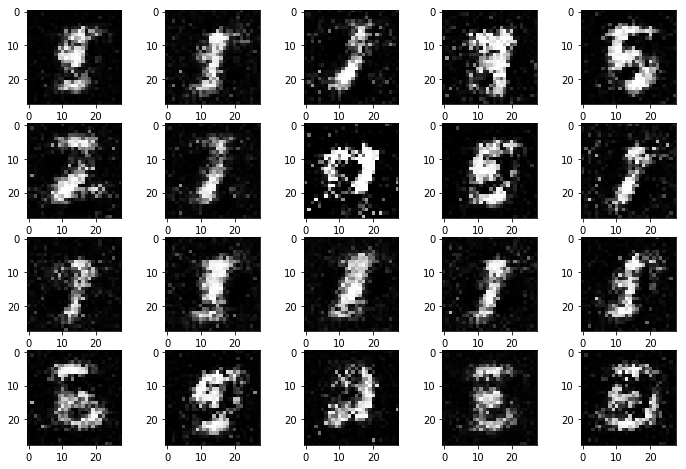

In [28]:
random_img =np.random.randint(0,np.array(l_img).shape[0])
print("Cada vez que se ejecute muestra una imagen aleatoria | epochs= ", random_img*100)
plt.figure(figsize=(12,8))
lote_img = np.array(l_img)[random_img]
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(lote_img[i].reshape(28,28), cmap="gray")

In [ ]:
n = 